# PROYECTO FINAL DE MINERÍA DE DATOS (EPG3341)

## Integrantes:  
* Matías Mayol (mgmayol@uc.cl)
* Hernán Silva (hjsilva@uc.cl)
* Jorge Utreras (jrutreras@uc.cl)


# I. Problemática y Objetivo

No es nuevo decir que grandes cantidades de datos o modelos complejos no son sinónimos ni garantía de lograr mejor información.  
El modelo más sofisticado no logrará buenos resultados si los datos están mal "tratados". Y por el contrario, hasta el modelo más simple logrará resultados positivos si la data está bien procesada y filtrada.

En este contexto y considerando la cantidad de datos disponibles, este trabajo tiene como propósito aplicar técnicas de procesamiento y minería de datos vistos durante el curso. Para ello, los objetivos planteados son los siguientes:

Armar una base de datos con información obtenida desde el origen.
Aplicar análisis utilizando las siguientes herramientas:

* Escalar
* Transformar Variables
* Aplicar glm logit para definir si la situación climática amerita o no generar una alerta de baja temperatura
* obtener curva ROC e indicadores asociados
* Ver comportamienteo con transformación de componentes principales(PCA)
* Aplicar métodos BackWard y Forward para evaluar y definir los predictores adecuados
* Emitir conclusiones

El objetivo de este proyecto es poder generar un algoritmo capaz de predecir qué variables predominan en la predicción de la temperatura bajo un límite parametrizado.

Para motivos de este análisis, se define como "alerta por baja temperatura", el caso en el que la temperatura de aire seco (dato ts) es menor a "7" grados. Con esta definición se crea la variable booleana, 1 para baja temperatura y 0 para alta temperatura.

# II. Acerca del origen de los datos

La Dirección Meteorológica de Chile posee datos de diversas variables en diferentes estaciones de monitoreo del país.
Para motivos de nuestro análisis, obtendremos desde el portal https://climatologia.meteochile.gob.cl/ datos que se encuentren en el rango de tiempo contemplado desde Enero del 2018 hasta Diciembre del 2019, correspondientes a la estación meteorológica del aeródromo de Pichilemu.
Estos datos corresponden a una lectura de condiciones climatológicas registradas cada un minuto.

Los datos recogidos se encuentran organizados de la siguiente forma:

* Una carpeta por cada estación de monitoreo (identificada con un número)
* Dentro de cada carpeta, hay un archivo csv por cada una de las variables de monitoreo
* Como se indicó anteriormente, nuestro análisis se basará en la estación de Pichilemu que se encuentra registrada en carpeta con código 340115.

## Las Estaciones Contienen: 
## Información del agua Caída: ##
|Campo|Unidad|Descripción|Método Obtención|
|---|---|---|---|
|rrInst|mm|Precipitación acumulada del minuto|Suma|
|rr6Horas|mm|Precipitación acumulada de 6 horas|Suma|
|rr24Horas|mm|Precipitación acumulada de 24 horas|Suma|

## Información de la presión y humedad: ##

|Campo|Unidad|Descripción|Método Obtención|
|---|---|---|---|
|hr|%|Humedad relativa|Censada|
|p0|hPa|Presión del sensor|Leída|
|qfe1|hPa|Presión reducida al nivel de la estación|Calculada|
|qff|hPa|Presión reducida al nivel medio del mar|Calculada|
|qnh|hPa|Presión reducida al nivel estándar|Calculada|

## Información de la Radiación: ##

|Campo|Unidad|Descripción|
|---|---|---|
|radiacionGlobalInst|$\frac{W}{m^2}$|Radiación Global Instantánea del minuto en watts/metro^2 |
|radiacionGlobalAcumulada24Horas|$\frac{Wh}{m^2}$|Radiación Global Acumulada diaria en wattshora/metro^2|

## Información del viento: ##

|Campo|Unidad|Descripción|
|---|---|---|
|ddInst|°|Dirección viento instantáneo en grados (entre 0 y 360) del segundo '00'|
|ffInst|kt|Intensidad del viento instantáneo en nudos (kt) del segundo '00'|
|dd02Minutos|°|Dirección promedio vectorial de 2 minutos|
|ff02Minutos|kt|Intensidad promedio de 2 minutos|
|dd10Minutos|°|Dirección promedio vectorial de 10 minutos|
|ff10Minutos|kt|Intensidad promedio de 10 minutos|

## Información de la temperatura: ##

|Campo|Unidad|Descripción|
|---|---|---|
|ts|°C|Temperatura del aire seco|
|td|°C|Temperatura del punto de rocío|
|tMin12Horas|°C|Temperatura Mínima 12 horas|
|tMax12Horas|°C|Temperatura Máxima 12 horas|
|horaTMin12Horas||Fecha y hora en UTC de la temperatura mínima|
|horaTMax12Horas||Fecha y hora en UTC de la temperatura máxima|

# III. Acerca de la implementación
El siguiente código fue diseñado para la lectura selectiva de cada uno de los diversos archivos csv alojados en las diferentes carpetas.
### La carpeta con los datos debe encontrarse en el directorio de trabajo (el archivo debe ser descomprimido en este lugar y debe tener como nombre el código 340115)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os

wd = os.getcwd()
wd = wd.replace('\\', '/')

## 3.a Funciones de lectura de Información:

La función "lecturaestacion", lee los archivos de la carpeta a analizar y obtiene los datos del rango Enero 2018 y Diciembre 2019

In [2]:
def lecturaestacion(numero,elemento):
    fechas = ('201802','201803','201804','201805','201806','201807','201808','201809','201810','201811','201812',
        '201901','201902','201903','201904','201905','201906','201907','201908','201909','201910','201911','201912')
    Datos = pd.read_csv(numero+'/'+numero+'_201801_'+elemento+'.csv',sep=';')
    for fec in fechas:
        direccion = wd +'/' +numero+'/'+numero+'_'+fec+'_'+elemento+'.csv'
        Datos2 = pd.read_csv(direccion,sep=';')
        Datos = pd.concat([Datos,Datos2])
    Largo_BD=len(Datos)
    columnas=list(Datos.columns.values)
    for col in columnas:
        if Datos[col].isna().sum()==Largo_BD:
            Datos=Datos.drop(columns=[col])
    if Datos['idEquipo'].sum()==0:
        Datos=Datos.drop(columns=['idEquipo'])
    return Datos

La función "leerbases" implementa la función "lecturaestacion" para cada una de las variables

In [3]:
def leerbases(numero):
    return {'Agua':lecturaestacion(numero,'AguaCaida'),'PrHu':lecturaestacion(numero,'PresionHumedad'),
           'Radi':lecturaestacion(numero,'RadiacionGlobal'),'Temp':lecturaestacion(numero,'Temperatura'),
           'Wind':lecturaestacion(numero,'Viento')}

La función "Armarbase" une la información de cada uno de los archivos obtenidos por función "leerbases" en un dataframe

In [4]:
def Armarbase(numero):
    Bases=leerbases(numero)
    Agua=Bases['Agua'].set_index('momento').loc[:,['rrInst','rr6Horas','rr24Horas']]
    PrHu=Bases['PrHu'].set_index('momento').loc[:,['hr','p0','qfe1','qff','qnh']]
    Radi=Bases['Radi'].set_index('momento').loc[:,['radiacionGlobalInst','radiacionGlobalAcumulada24Horas']]
    Wind=Bases['Wind'].set_index('momento').loc[:,['ddInst','ffInst','dd02Minutos','ff02Minutos','dd10Minutos','ff10Minutos']]
    Temp=Bases['Temp'].set_index('momento').loc[:,['ts','td','tMin12Horas','tMax12Horas','horaTMin12Horas','horaTMax12Horas']]
    Base=Agua.join(PrHu,how='outer').join(Radi,how='outer').join(Wind,how='outer').join(Temp,how='outer')
    Base2=Instantes(Base)
    return Base2

La función "Instantes" es utilizada por función "Armarbase" para desglosar las variables temporales como años, meses, días, horas y minutos, y, calcular Hora_Min_t y Hora_Max_t

In [5]:
def Instantes(Bases):
    Aux=Bases.reset_index()
    Aux=Aux[Aux.isna().sum(1)==0]
    Aux['Anno'] = pd.to_datetime(Aux['momento']).map(lambda x: x.year).astype('uint16')
    Aux['Mes'] = pd.to_datetime(Aux['momento']).map(lambda x: x.month).astype('uint8')
    Aux['Dia'] = pd.to_datetime(Aux['momento']).map(lambda x: x.day).astype('uint8')
    Aux['Hora'] = pd.to_datetime(Aux['momento']).map(lambda x: x.hour).astype('uint8')
    Aux['Minuto'] = pd.to_datetime(Aux['momento']).map(lambda x: x.minute).astype('uint8')
    Aux['momento']=pd.to_datetime(Aux['momento'])
    Aux['Hora_Min_t'] = pd.to_datetime(Aux['horaTMin12Horas']).map(lambda x: x.hour).astype('uint8')
    Aux['Hora_Max_t'] = pd.to_datetime(Aux['horaTMax12Horas']).map(lambda x: x.hour).astype('uint8')
    Aux=Aux.drop(columns=['horaTMin12Horas','horaTMax12Horas'])
    return Aux

## 3.b Funciones Para mostrar la base de datos por estación:

La función "DibujaCorr" grafica las correlaciones entre las variables.  
La función "dibujarbd" muestra las variables contra el tiempo.  
La función "graficar_densidades" muestra gráficamente las densidades de las variables.

In [6]:
def Dibujacorr(BD):
    plt.matshow(abs(BD.corr()))
    plt.xticks(range(len(BD.columns)), BD.columns)
    plt.yticks(range(len(BD.columns)), BD.columns)
    plt.colorbar()
    plt.show()
    print(BD.corr()['ts'].round(3))
    print('NANs:')
    display(BD.isnull().sum())
    display(BD)
    
def dibujarbd(BD):
    x=BD['momento']
    for k in ('rrInst','rr6Horas','rr24Horas'):
        plt.scatter(x,BD[k],s=0.4,label=k)
    plt.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.xticks(rotation=60)
    plt.show()
    for k in ('hr','p0','qfe1','qff','qnh'):
        plt.scatter(x,BD[k],s=0.4,label=k)
    plt.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.xticks(rotation=60)
    plt.show()
    for k in ('radiacionGlobalInst','radiacionGlobalAcumulada24Horas'):
        plt.scatter(x,BD[k],s=0.4,label=k)
    plt.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.xticks(rotation=60)
    plt.show()
    for k in ('ddInst','ffInst','dd02Minutos','ff02Minutos','dd10Minutos','ff10Minutos'):
        plt.scatter(x,BD[k],s=0.4,label=k)
    plt.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.xticks(rotation=60)
    plt.show()
    for k in ('ts','td','tMin12Horas','tMax12Horas'):
        plt.scatter(x,BD[k],s=0.4,label=k)
    plt.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.xticks(rotation=60)
    plt.show()
    Dibujacorr(BD)

def graficar_densidades(BD,bins=24):
    if ('momento' in BD.columns):
        BD2=BD.drop(columns=['momento'])
    else:
        BD2=BD
    largo=len(BD2)
    display(BD2.describe())
    for k in BD2.columns:
        print(k)
        aux=pd.DataFrame()
        aux.loc['Máximo','Valor']=round(BD2[k].max(),4)
        aux.loc['Mínomo','Valor']=round(BD2[k].min(),4)
        aux.loc['Media','Valor']=round(BD2[k].mean(),4)
        aux.loc['Mediana','Valor']=round(BD2[k].median(),4)
        aux.loc['Desviación Estándar','Valor']=round(BD2[k].std(),4)
        aux.loc['Asimetría','Valor']=round(sum(aux.loc['Mediana','Valor']-BD2[k])/aux.loc['Desviación Estándar','Valor']/len(BD2[k]),4)
        print(aux)
        plt.hist(BD2[k],label=k,bins=bins)
        plt.legend(loc='upper right', shadow=True, fontsize='x-large')
        plt.xticks(rotation=60)
        plt.show()

La función "escalar" escala mediante la división entre la resta de los datos y su media, y su desviación estandar  
La función "transforVariables" implementa las siguientes lógicas de transformación: categórica, categórica booleana y logarítmica.  
La función "Transformar" implementa función "transforVariables" de acuerdo a los criterios obtenidos en gráficos de densidades.

In [7]:
def escalar(BD):
    if ('momento' in BD.columns):
        BD2=BD.drop(columns=['momento'])
    else:
        BD2=BD
    largo=len(BD2)
    BD3=pd.DataFrame()
    for k in BD2.columns:
        BD3[k]=(BD2[k]-BD2[k].mean())/BD2[k].std()
    return(BD3)

def transforVariables(data, bool_trans=[],log_trans=[], cat_trans=[], max_bins=2):
    df = data.copy()
    if len(bool_trans)>0:
        for i in bool_trans:
            df[i]=1*(df[i]>0)  # el +1 es por los 0s
    if len(log_trans) > 0:     
        for i in log_trans:
            df[i] = np.log(df[i] + 1)  # el +1 es por los 0s
    if cat_trans:
        for i in cat_trans:
            df[i] = pd.qcut(df[i], q=max_bins, labels=range(max_bins)).astype(int) # pd.qcut, pd.cut
    return df

def Transformar(BD,bins):
    BD2=BD.copy()
    BD3=transforVariables(BD2,log_trans=['radiacionGlobalInst','radiacionGlobalAcumulada24Horas',
                                         'rr24Horas','rr6Horas','rrInst','ddInst','dd02Minutos',
                                         'dd10Minutos'],
                          bool_trans=[],
                          cat_trans=['p0','qfe1','qnh'],
                          #Empeoran arbol agregar a cat: 'hr' 'qff'
                          max_bins=bins)
    return(BD3)

La función "Principales" realiza la transformación de las variables Principales.  
La función "Regresionlineal_PCA" realiza las siguientes tareas:
* Gráfico de correlaciones
* Gráfico de varianza acumulada explicada por los componentes
* Gráfico de componentes vs componentes 
* Muestra un resultado de predicciones de una regresión lineal

In [8]:
def Principales(BD,cuantos=19):
    X=BD
    #Hasta este punto se definio X e Y
    fig, ax = plt.subplots(figsize=(15,10))   
    sns.heatmap(X.corr(), annot=False, cmap="RdBu_r")
    plt.show()
    Xstd = StandardScaler().fit_transform(X) # escalar
    pca = PCA()
    pc = pca.fit(Xstd)
    Xreg = pca.transform(Xstd)
    print((pc.explained_variance_/np.sum(pc.explained_variance_))[:cuantos])
    print(np.cumsum(pc.explained_variance_/np.sum(pc.explained_variance_))[:cuantos])
    sns.lineplot(range(Xreg.shape[1]), np.cumsum(pc.explained_variance_/np.sum(pc.explained_variance_)))
    plt.show()
    print(Xreg)
    return(Xreg)

def Regresionlineal_PCA(BD_Original,BD_Trabajada,delta,limite=7,regresores = 20):
    BD=BD_Trabajada
    largo=len(BD)
    X=BD
    Y=BD_Original
    X=X.reset_index().drop(columns=['index']).loc[0:largo-delta]
    Y=Y.reset_index().drop(columns=['index']).loc[delta-1:largo].reset_index().drop(columns=['index'])
    Y=Y['ts']
    Y=(Y<limite).astype(int)
    Xreg=Principales(X)
    Xregd = pd.DataFrame(Xreg, columns=['cp{:03d}'.format(i+1) for i in range(Xreg.shape[1])])
    Xregd = Xregd.assign(y=Y, yc=pd.qcut(Y, q=[0, 1]))
    print(Xregd.head())
    Xregd = pd.DataFrame(Xreg, columns=['cp{:03d}'.format(i+1) for i in range(Xreg.shape[1])])
    Xregd = Xregd.assign(y=Y, yc=pd.qcut(Y, q=[0, 1]))
    print(Xregd.head())
    fig, ax = plt.subplots(figsize=(10,8))
    sns.scatterplot("cp001", "cp002", hue='yc', palette='dark', data=Xregd)
    plt.show()
    fig, ax = plt.subplots(figsize=(10,8))
    sns.scatterplot("cp001", "cp003", hue='yc', palette='dark', data=Xregd)
    plt.show()
    #####Predicciones:
    n = Xreg.shape[0]
    regr = linear_model.LinearRegression()
    regr.fit(Xreg[:,:regresores], Y)
    y_c = regr.predict(Xreg[:,:regresores])
    display(r2_score(Y, y_c))
    display(1 - (1 - r2_score(Y, y_c)) * (n - 1)/(n - regresores - 1))
    display(mean_squared_error(Y, y_c))

## 3.c Funciones para obtener el valor (IV) y ganancia (IG) de la información: 

Se implementa funcion "Inf_Value" para obtener IV, y función "Inf_Gain" para obtener IG.  
Definimos usar ambas funciones con un sample de datos dada la magnitud de la información lo que afecta en el tiempo de ejecución.

In [9]:
def Inf_Value(BD_Original,BD_Trabajada,delta=40,limite=7,Sample=20000,seed=2020):
    BD=BD_Trabajada
    largo=len(BD)
    X=BD
    Y=BD_Original
    X=X.reset_index().loc[0:largo-delta].sample(Sample,random_state=seed)
    X=X.sort_index('index').drop(columns=['index'])
    Y=Y.reset_index().drop(columns=['index']).loc[delta-1:largo].reset_index().sample(Sample,random_state=seed)
    Y=Y.sort_index('index').drop(columns=['index'])
    Y=Y['ts']
    Y=Y<limite
    IV=pd.DataFrame()
    for k in X.columns:
        IV.loc[k,'IV']=0
        Col=X[k]
        grupitos=Col.unique()
        for j in grupitos:
            pceros=sum(Y[Col==j]==False)/(1+sum(Y[Col==j]==False)+sum(Y[Col==j]==True))
            punos=sum(Y[Col==j]==True)/(1+sum(Y[Col==j]==False)+sum(Y[Col==j]==True))
            IV.loc[k,'IV']=IV.loc[k,'IV']+(pceros-punos)*(np.log(pceros+1)-np.log(punos+1))
            #Sumo uno para evitar el log(0)
    IV=IV.sort_values(by='IV')
    print(IV)
    
def Inf_Gain(BD_Original,BD_Trabajada,delta=40,limite=7,Sample=20000,seed=2020):
    BD=BD_Trabajada
    largo=len(BD)
    X=BD
    Y=BD_Original
    X=X.reset_index().loc[0:largo-delta].sample(Sample,random_state=seed)
    X=X.sort_index('index').drop(columns=['index'])
    Y=Y.reset_index().drop(columns=['index']).loc[delta-1:largo].reset_index().sample(Sample,random_state=seed)
    Y=Y.sort_index('index').drop(columns=['index'])
    Y=Y['ts']
    Y=Y<limite
    IG=pd.DataFrame()
    for k in X.columns:
        IG.loc[k,'IG']=0
        Col=X[k]
        grupitos=Col.unique()
        for j in grupitos:
            pceros=sum(Y[Col==j]==False)+1
            punos=sum(Y[Col==j]==True)+1
            P_j=punos/(pceros+punos)
            IG.loc[k,'IG']=IG.loc[k,'IG']-P_j*np.log(P_j)
            #Sumo uno en todos los casos, no afecta la comparacion, pero permite evitar el log(0)
    IG=IG.sort_values(by='IG')
    print(IG)    

## 3.d Funciones para predecir

Se implementa función "Arbol" que construye un árbol de decisión para predecir una variable dicotómica en relación a las alarmas por baja temperatura.

In [10]:
def Arbol(BD_Original,BD_Trabajada,delta=40,Profundidad=5,limite=7):
    BD=BD_Trabajada
    largo=len(BD)
    X=BD
    Y=BD_Original
    X=X.reset_index().loc[0:largo-delta].drop(columns=['index'])
    Y=Y.reset_index().drop(columns=['index']).loc[delta-1:largo].reset_index().drop(columns=['index'])
    Y=Y['ts']
    Y=Y<limite
    largo=len(Y)
    #70%
    n=round(0.7*largo,0)
    X_train=X.loc[0:n].astype(float)
    X_test=X.loc[n:largo].reset_index().drop(columns=['index']).astype(float)
    y_train=Y.loc[0:n].astype(float)
    y_test=Y.loc[n:largo].reset_index().drop(columns=['index']).astype(float)
    dt = DecisionTreeClassifier(max_depth = Profundidad)
    dt.fit(X_train,y_train)
    Y_Gorro=dt.predict(X_test)
    Aux=pd.DataFrame()
    Aux['Arbol']=Y_Gorro
    Aux=pd.concat([Aux,y_test],axis=1)
    CON=pd.DataFrame(confusion_matrix(y_test, Y_Gorro))
    ACCURACY=(CON.iloc[0,0]+CON.iloc[1,1])/(CON.iloc[0,0]+CON.iloc[0,1]+CON.iloc[1,0]+CON.iloc[1,1])
    print('ACCURACY:')
    print(ACCURACY)
    return([dt,CON])

Se implementa función "Logit" que ejecuta una regresión glm logit para predecir una variable dicotómica en relación a las alarmas por baja temperatura. 

In [11]:
def Logit(BD_Original,BD_Trabajada,delta=40,limite=7):
    BD=BD_Trabajada
    largo=len(BD)
    X=BD
    Y=BD_Original
    X=X.reset_index().loc[0:largo-delta].drop(columns=['index'])
    Y=Y.reset_index().drop(columns=['index']).loc[delta-1:largo].reset_index().drop(columns=['index'])
    Y=Y['ts']
    Y=Y<limite
    largo=len(Y)
    #70%
    n=round(0.7*largo,0)
    X_train=X.loc[0:n].astype(float)
    X_test=X.loc[n:largo].reset_index().drop(columns=['index']).astype(float)
    y_train=Y.loc[0:n].astype(float)
    y_test=Y.loc[n:largo].reset_index().drop(columns=['index']).astype(float)
    fit_1 = sm.Logit(y_train,X_train)
    fit_1 = fit_1.fit()
#    display(fit_1.summary())
    display(fit_1.summary2())
    #puntuaciones
    criteria = ['gini', 'entropy'] 
    scores = {}
    for c in criteria:
        dt = DecisionTreeClassifier(criterion = c) 
        dt.fit(X_train, y_train) 
        test_score = dt.score(X_test, y_test) 
        scores[c] = test_score 
    print(scores) 
    #Confusion:
    y_predicted = (fit_1.predict(X_test) <= 0.1)*1
    logistic_CM = pd.DataFrame(confusion_matrix(y_test, y_predicted))
    Minimo=round(100*min(fit_1.predict(X_test)))
    Maximo=round(100*max(fit_1.predict(X_test)))
    Comparador=0
    for k in range(Minimo,Maximo):
        aux=k/100
        y_predicted_aux = (fit_1.predict(X_test) >= aux)*1
        CON=pd.DataFrame(confusion_matrix(y_test, y_predicted_aux))
        ACCURACY=(CON.iloc[0,0]+CON.iloc[1,1])/(CON.iloc[0,0]+CON.iloc[0,1]+CON.iloc[1,0]+CON.iloc[1,1])
        COMp= ACCURACY
        if Comparador<COMp:
            y_predicted = y_predicted_aux
            logistic_CM = CON
            Comparador=COMp
    print('Confusion Matrix :')
    print(logistic_CM)
    print('Accuracy Score :',accuracy_score(y_test, y_predicted))
    print('Report : ')
    print(classification_report(y_test, y_predicted))
    #Curva ROC
    plt.rc("font", size=14)
    sns.set(style="white")
    sns.set(style="whitegrid", color_codes=True)
    logit_roc_auc = roc_auc_score(Y, fit_1.predict(X))
    print('ROC_AUC_score:')
    print(logit_roc_auc)
    fpr, tpr, thresholds = roc_curve(Y, fit_1.predict(X))
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Especificidad [False Positive Rate, FPR)]')
    plt.ylabel('Sensibilidad [True Positive Rate, TPR]')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    return(fit_1.summary2())

Se implementa función "Backward_Logit" que ejecuta un algoritmo Backward con función logit para eliminar predictores no significativos a través de la lecturas de valor-p menor a 0,05; y así predecir una variable dicotómica en relación a las alarmas por baja temperatura. 

In [12]:
def Backward_Logit(BD_Original,BD_Trabajada,delta=40,limite=7):
    SUMM=Logit(BD_Original,BD_Trabajada,delta=delta,limite=limite)
    For=pd.read_html(SUMM.as_html())[1]
    Columnas=For.iloc[0]
    Columnas[0]='Predictor'
    For.columns = For.iloc[0]
    For = For.drop(For.index[0])
    For
    quitar =max(For['P>|z|'])
    Columnaquitar=For.loc[For['P>|z|']==quitar,'Predictor']
    print(quitar)
    print(Columnaquitar)
    if quitar < '0.05':
        print('Seleccion Backward:')
        print(For.loc[:,'Predictor'])
    else:
        Backward_Logit(BD_Original,BD_Trabajada.drop(columns=Columnaquitar),delta=delta,limite=limite)

 Se construye función "forward_selected" que ejecuta un algoritmo Forward para determinar predictores que maximizan r cuadrado ajustado.

In [13]:
def forward_selected(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            print('formula : ' + formula)
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

Se construye función "Forward" que implementa función "forward_selected" e invoca función "logit" con variables seleccionadas y asi predecir una variable dicotómica en relación a las alarmas por baja temperatura. 

In [14]:
def Forward(BD_Original,BD_Trabajada,delta=40,limite=7):
    BD=BD_Trabajada
    largo=len(BD)
    X=BD
    Y=BD_Original
    X=X.reset_index().loc[0:largo-delta].drop(columns=['index'])
    Y=Y.reset_index().drop(columns=['index']).loc[delta-1:largo].reset_index().drop(columns=['index'])
    Y=Y['ts']
    Y=Y<limite
    largo=len(Y)
    #70%
    n=round(0.7*largo,0)
    X_train=X.loc[0:n].astype(float)
    X_test=X.loc[n:largo].reset_index().drop(columns=['index']).astype(float)
    y_train=Y.loc[0:n].astype(float)
    y_test=Y.loc[n:largo].reset_index().drop(columns=['index']).astype(float)
    XYTrain=X_train.copy()
    XYTrain['ts2']=y_train
    model = forward_selected(XYTrain, 'ts2')
    print(model.model.formula)
    print(model.rsquared_adj)
    Columnas=X.columns
    colsModel = []
    for c in Columnas:
        if c in model.model.formula:
            colsModel.append(c)
    BD_Trabajada2=BD_Trabajada[colsModel]
    Logit(BD_Original,BD_Trabajada2,delta=delta,limite=limite)

# IV. Desarrollo utilizando funciones implementadas

Se procede a armar base de datos

In [15]:
Pichilemu=Armarbase('340115')

In [16]:
Pichilemu

,momento,rrInst,rr6Horas,rr24Horas,hr,p0,qfe1,qff,qnh,radiacionGlobalInst,...,td,tMin12Horas,tMax12Horas,Anno,Mes,Dia,Hora,Minuto,Hora_Min_t,Hora_Max_t
0,2018-01-10 02:31:00,0.0,0.0,0.0,92.6,1010.4,1010.5,1014.1,1014.1,0.0,...,13.6,15.5,16.6,2018,1,10,2,31,23,22
1,2018-01-10 02:32:00,0.0,0.0,0.0,92.5,1010.4,1010.5,1014.1,1014.1,0.0,...,13.6,15.5,16.6,2018,1,10,2,32,23,22
2,2018-01-10 02:33:00,0.0,0.0,0.0,92.6,1010.3,1010.5,1014.1,1014.1,0.0,...,13.6,15.5,16.6,2018,1,10,2,33,23,22
3,2018-01-10 02:34:00,0.0,0.0,0.0,92.5,1010.3,1010.4,1014.0,1014.0,0.0,...,13.6,15.5,16.6,2018,1,10,2,34,23,22
4,2018-01-10 02:35:00,0.0,0.0,0.0,92.5,1010.4,1010.4,1014.0,1014.0,0.0,...,13.6,15.5,16.6,2018,1,10,2,35,23,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034574,2019-12-31 23:56:00,0.0,0.0,0.0,84.9,1009.5,1009.7,1013.3,1013.3,2.9,...,12.9,10.9,15.0,2019,12,31,23,56,9,0
1034575,2019-12-31 23:57:00,0.0,0.0,0.0,85.0,1009.5,1009.6,1013.2,1013.2,2.0,...,13.0,10.9,15.0,2019,12,31,23,57,9,0
1034576,2019-12-31 23:58:00,0.0,0.0,0.0,85.0,1009.5,1009.7,1013.3,1013.3,1.3,...,12.9,10.9,15.0,2019,12,31,23,58,9,0
1034577,2019-12-31 23:59:00,0.0,0.0,0.0,84.9,1009.5,1009.7,1013.3,1013.3,0.6,...,12.8,10.9,15.0,2019,12,31,23,59,9,0


Se procede a obtener gráficos en donde se visualizan correlaciones y variables en el tiempo
También se obtiene resumen de presencia de NaNs y matriz de correlaciones vs variables a predecir (ts); además de una muestra de la Base de Datos.

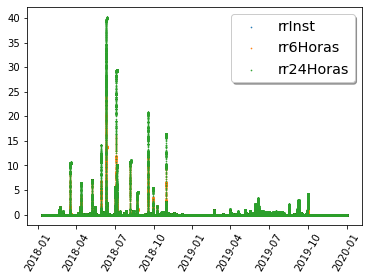

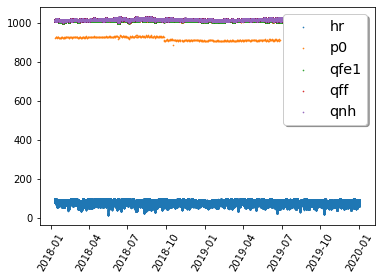

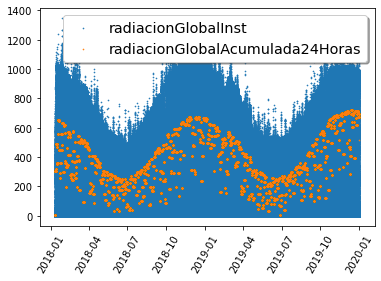

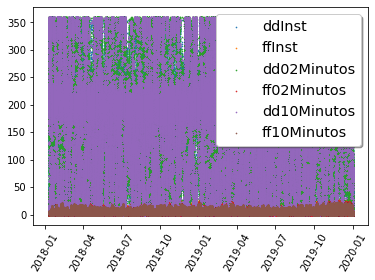

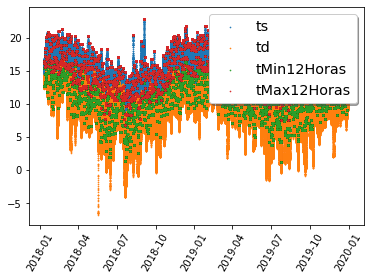

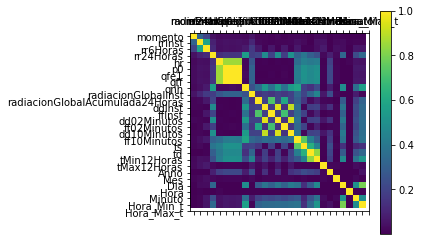

rrInst                            -0.018
rr6Horas                          -0.036
rr24Horas                         -0.066
hr                                -0.318
p0                                -0.355
qfe1                              -0.415
qff                               -0.424
qnh                               -0.415
radiacionGlobalInst                0.592
radiacionGlobalAcumulada24Horas    0.338
ddInst                             0.303
ffInst                             0.358
dd02Minutos                        0.338
ff02Minutos                        0.371
dd10Minutos                        0.338
ff10Minutos                        0.382
ts                                 1.000
td                                 0.748
tMin12Horas                        0.433
tMax12Horas                        0.284
Anno                               0.009
Mes                               -0.179
Dia                               -0.006
Hora                               0.377
Minuto          

momento                            0
rrInst                             0
rr6Horas                           0
rr24Horas                          0
hr                                 0
p0                                 0
qfe1                               0
qff                                0
qnh                                0
radiacionGlobalInst                0
radiacionGlobalAcumulada24Horas    0
ddInst                             0
ffInst                             0
dd02Minutos                        0
ff02Minutos                        0
dd10Minutos                        0
ff10Minutos                        0
ts                                 0
td                                 0
tMin12Horas                        0
tMax12Horas                        0
Anno                               0
Mes                                0
Dia                                0
Hora                               0
Minuto                             0
Hora_Min_t                         0
H

,momento,rrInst,rr6Horas,rr24Horas,hr,p0,qfe1,qff,qnh,radiacionGlobalInst,...,td,tMin12Horas,tMax12Horas,Anno,Mes,Dia,Hora,Minuto,Hora_Min_t,Hora_Max_t
0,2018-01-10 02:31:00,0.0,0.0,0.0,92.6,1010.4,1010.5,1014.1,1014.1,0.0,...,13.6,15.5,16.6,2018,1,10,2,31,23,22
1,2018-01-10 02:32:00,0.0,0.0,0.0,92.5,1010.4,1010.5,1014.1,1014.1,0.0,...,13.6,15.5,16.6,2018,1,10,2,32,23,22
2,2018-01-10 02:33:00,0.0,0.0,0.0,92.6,1010.3,1010.5,1014.1,1014.1,0.0,...,13.6,15.5,16.6,2018,1,10,2,33,23,22
3,2018-01-10 02:34:00,0.0,0.0,0.0,92.5,1010.3,1010.4,1014.0,1014.0,0.0,...,13.6,15.5,16.6,2018,1,10,2,34,23,22
4,2018-01-10 02:35:00,0.0,0.0,0.0,92.5,1010.4,1010.4,1014.0,1014.0,0.0,...,13.6,15.5,16.6,2018,1,10,2,35,23,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034574,2019-12-31 23:56:00,0.0,0.0,0.0,84.9,1009.5,1009.7,1013.3,1013.3,2.9,...,12.9,10.9,15.0,2019,12,31,23,56,9,0
1034575,2019-12-31 23:57:00,0.0,0.0,0.0,85.0,1009.5,1009.6,1013.2,1013.2,2.0,...,13.0,10.9,15.0,2019,12,31,23,57,9,0
1034576,2019-12-31 23:58:00,0.0,0.0,0.0,85.0,1009.5,1009.7,1013.3,1013.3,1.3,...,12.9,10.9,15.0,2019,12,31,23,58,9,0
1034577,2019-12-31 23:59:00,0.0,0.0,0.0,84.9,1009.5,1009.7,1013.3,1013.3,0.6,...,12.8,10.9,15.0,2019,12,31,23,59,9,0


In [17]:
dibujarbd(Pichilemu)

Se procede a graficar densidades de variables de la base de datos

,rrInst,rr6Horas,rr24Horas,hr,p0,qfe1,qff,qnh,radiacionGlobalInst,radiacionGlobalAcumulada24Horas,...,td,tMin12Horas,tMax12Horas,Anno,Mes,Dia,Hora,Minuto,Hora_Min_t,Hora_Max_t
count,1.034033e+06,1.034033e+06,1.034033e+06,1.034033e+06,1.034033e+06,1.034033e+06,1.034033e+06,1.034033e+06,1.034033e+06,1.034033e+06,...,1.034033e+06,1.034033e+06,1.034033e+06,1.034033e+06,1.034033e+06,1.034033e+06,1.034033e+06,1.034033e+06,1.034033e+06,1.034033e+06
mean,3.185585e-04,5.493065e-02,2.344814e-01,8.129102e+01,1.013802e+03,1.014030e+03,1.017668e+03,1.017640e+03,1.935085e+02,3.746523e+02,...,9.722461e+00,1.083755e+01,1.508991e+01,2.018507e+03,6.586987e+00,1.586876e+01,1.149714e+01,2.947000e+01,1.165162e+01,1.000397e+01
std,6.869434e-03,5.747839e-01,1.772791e+00,1.054651e+01,4.154163e+00,3.564238e+00,3.592921e+00,3.574486e+00,2.879615e+02,1.796930e+02,...,2.955311e+00,2.890128e+00,2.819768e+00,4.999539e-01,3.409815e+00,8.758940e+00,6.925863e+00,1.732719e+01,5.282626e+00,8.002501e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e+01,8.862000e+02,1.000900e+03,1.004500e+03,1.004500e+03,0.000000e+00,1.800000e+00,...,-6.700000e+00,1.300000e+00,6.900000e+00,2.018000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,7.440000e+01,1.011400e+03,1.011600e+03,1.015200e+03,1.015200e+03,0.000000e+00,2.414000e+02,...,8.200000e+00,9.000000e+00,1.310000e+01,2.018000e+03,4.000000e+00,8.000000e+00,5.000000e+00,1.400000e+01,9.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,8.300000e+01,1.013500e+03,1.013700e+03,1.017300e+03,1.017300e+03,1.300000e+00,3.451000e+02,...,1.010000e+01,1.100000e+01,1.490000e+01,2.019000e+03,7.000000e+00,1.600000e+01,1.100000e+01,2.900000e+01,1.100000e+01,1.200000e+01
75%,0.000000e+00,0.000000e+00,0.000000e+00,8.930000e+01,1.015900e+03,1.016100e+03,1.019800e+03,1.019700e+03,3.304000e+02,5.215000e+02,...,1.180000e+01,1.300000e+01,1.700000e+01,2.019000e+03,1.000000e+01,2.300000e+01,1.800000e+01,4.400000e+01,1.200000e+01,1.700000e+01
max,1.600000e+00,2.510000e+01,4.020000e+01,9.960000e+01,1.027300e+03,1.027500e+03,1.031200e+03,1.031100e+03,1.347300e+03,7.209000e+02,...,1.700000e+01,1.770000e+01,2.320000e+01,2.020000e+03,1.200000e+01,3.100000e+01,2.300000e+01,5.900000e+01,2.300000e+01,2.300000e+01


rrInst
                      Valor
Máximo               1.6000
Mínomo               0.0000
Media                0.0003
Mediana              0.0000
Desviación Estándar  0.0069
Asimetría           -0.0462


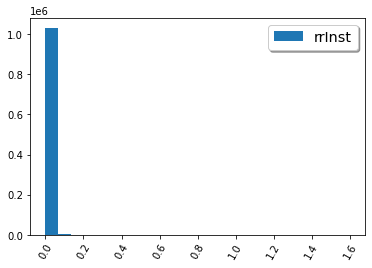

rr6Horas
                       Valor
Máximo               25.1000
Mínomo                0.0000
Media                 0.0549
Mediana               0.0000
Desviación Estándar   0.5748
Asimetría            -0.0956


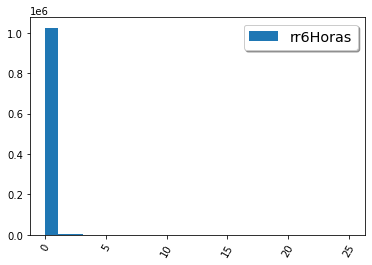

rr24Horas
                       Valor
Máximo               40.2000
Mínomo                0.0000
Media                 0.2345
Mediana               0.0000
Desviación Estándar   1.7728
Asimetría            -0.1323


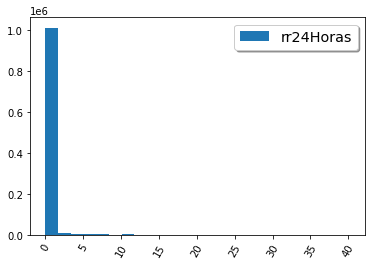

hr
                       Valor
Máximo               99.6000
Mínomo               19.0000
Media                81.2910
Mediana              83.0000
Desviación Estándar  10.5465
Asimetría             0.1620


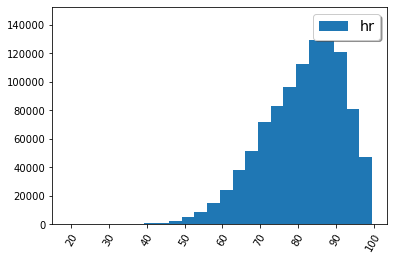

p0
                         Valor
Máximo               1027.3000
Mínomo                886.2000
Media                1013.8016
Mediana              1013.5000
Desviación Estándar     4.1542
Asimetría              -0.0726


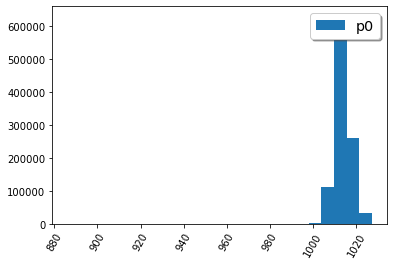

qfe1
                         Valor
Máximo               1027.5000
Mínomo               1000.9000
Media                1014.0299
Mediana              1013.7000
Desviación Estándar     3.5642
Asimetría              -0.0926


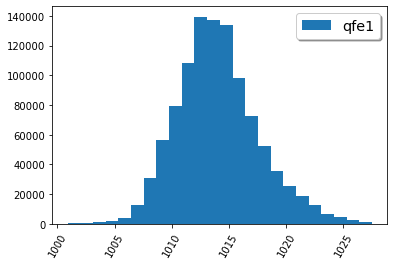

qff
                         Valor
Máximo               1031.2000
Mínomo               1004.5000
Media                1017.6683
Mediana              1017.3000
Desviación Estándar     3.5929
Asimetría              -0.1025


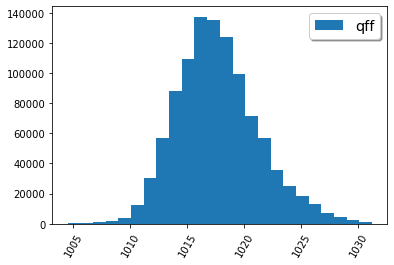

qnh
                         Valor
Máximo               1031.1000
Mínomo               1004.5000
Media                1017.6403
Mediana              1017.3000
Desviación Estándar     3.5745
Asimetría              -0.0952


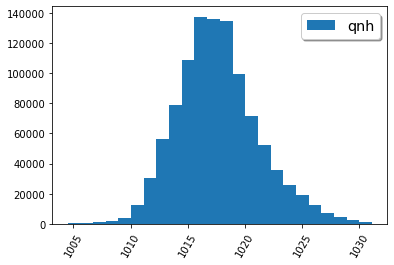

radiacionGlobalInst
                         Valor
Máximo               1347.3000
Mínomo                  0.0000
Media                 193.5085
Mediana                 1.3000
Desviación Estándar   287.9615
Asimetría              -0.6675


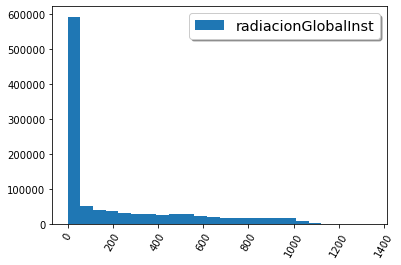

radiacionGlobalAcumulada24Horas
                        Valor
Máximo               720.9000
Mínomo                 1.8000
Media                374.6523
Mediana              345.1000
Desviación Estándar  179.6930
Asimetría             -0.1645


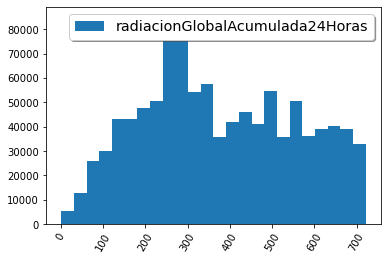

ddInst
                        Valor
Máximo               360.0000
Mínomo                 0.0000
Media                173.4709
Mediana              190.6000
Desviación Estándar   86.5871
Asimetría              0.1978


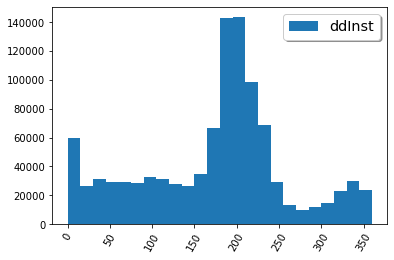

ffInst
                       Valor
Máximo               28.7000
Mínomo                0.0000
Media                 5.2272
Mediana               4.3000
Desviación Estándar   3.8764
Asimetría            -0.2392


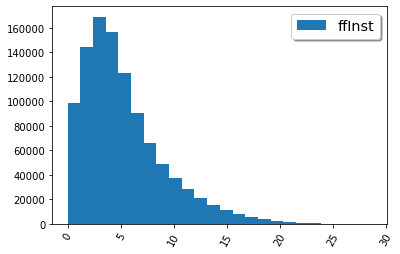

dd02Minutos
                        Valor
Máximo               360.0000
Mínomo                 0.0000
Media                176.7066
Mediana              193.7000
Desviación Estándar   87.7763
Asimetría              0.1936


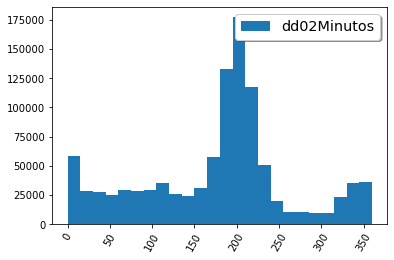

ff02Minutos
                       Valor
Máximo               26.1000
Mínomo                0.0000
Media                 5.2280
Mediana               4.4000
Desviación Estándar   3.7402
Asimetría            -0.2214


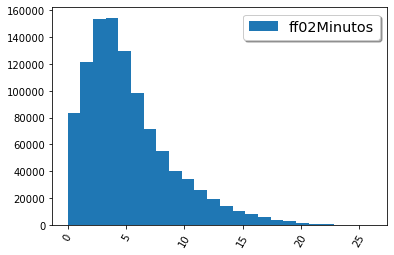

dd10Minutos
                        Valor
Máximo               360.0000
Mínomo                 0.0000
Media                179.6440
Mediana              194.9000
Desviación Estándar   85.3412
Asimetría              0.1788


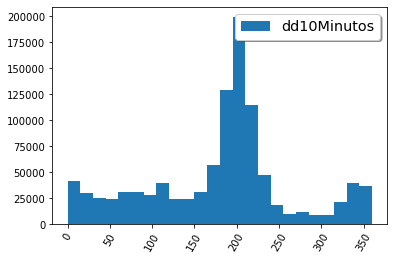

ff10Minutos
                       Valor
Máximo               22.2000
Mínomo                0.0000
Media                 5.2278
Mediana               4.4000
Desviación Estándar   3.6307
Asimetría            -0.2280


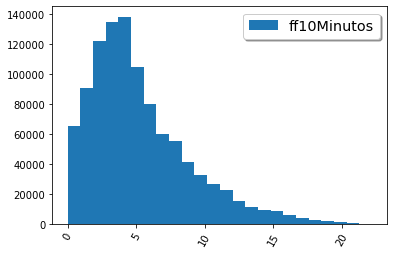

ts
                       Valor
Máximo               23.0000
Mínomo                1.4000
Media                12.9762
Mediana              12.9000
Desviación Estándar   2.9465
Asimetría            -0.0259


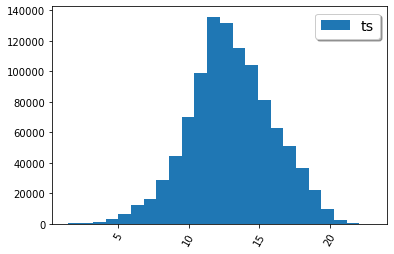

td
                       Valor
Máximo               17.0000
Mínomo               -6.7000
Media                 9.7225
Mediana              10.1000
Desviación Estándar   2.9553
Asimetría             0.1277


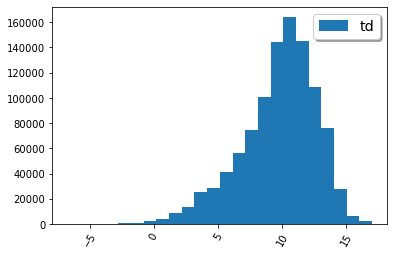

tMin12Horas
                       Valor
Máximo               17.7000
Mínomo                1.3000
Media                10.8375
Mediana              11.0000
Desviación Estándar   2.8901
Asimetría             0.0562


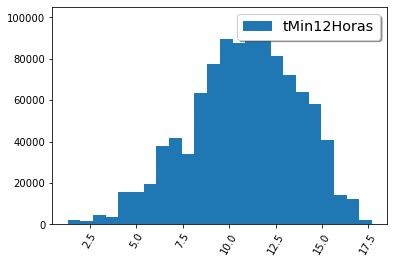

tMax12Horas
                       Valor
Máximo               23.2000
Mínomo                6.9000
Media                15.0899
Mediana              14.9000
Desviación Estándar   2.8198
Asimetría            -0.0673


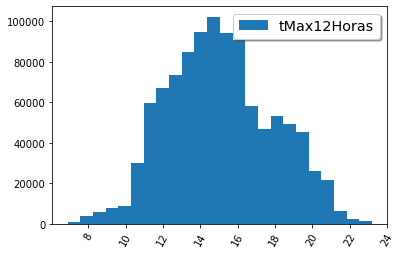

Anno
                         Valor
Máximo               2020.0000
Mínomo               2018.0000
Media                2018.5070
Mediana              2019.0000
Desviación Estándar     0.5000
Asimetría               0.9861


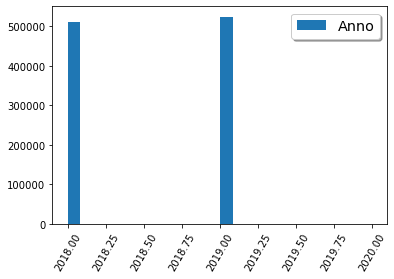

Mes
                       Valor
Máximo               12.0000
Mínomo                1.0000
Media                 6.5870
Mediana               7.0000
Desviación Estándar   3.4098
Asimetría             0.1211


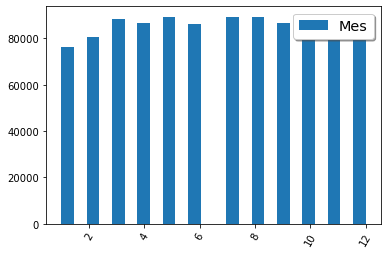

Dia
                       Valor
Máximo               31.0000
Mínomo                1.0000
Media                15.8688
Mediana              16.0000
Desviación Estándar   8.7589
Asimetría             0.0150


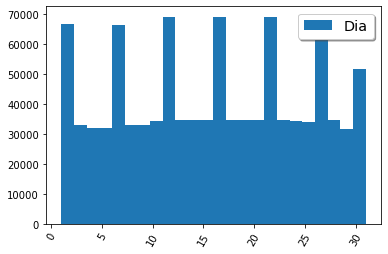

Hora
                       Valor
Máximo               23.0000
Mínomo                0.0000
Media                11.4971
Mediana              11.0000
Desviación Estándar   6.9259
Asimetría            -0.0718


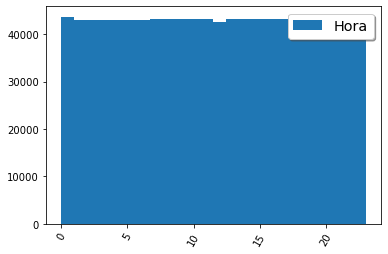

Minuto
                       Valor
Máximo               59.0000
Mínomo                0.0000
Media                29.4700
Mediana              29.0000
Desviación Estándar  17.3272
Asimetría            -0.0271


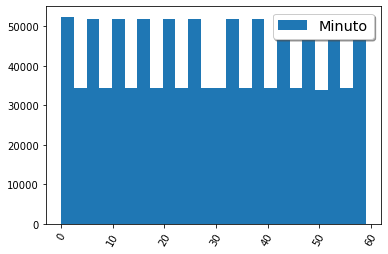

Hora_Min_t
                       Valor
Máximo               23.0000
Mínomo                0.0000
Media                11.6516
Mediana              11.0000
Desviación Estándar   5.2826
Asimetría            -0.1234


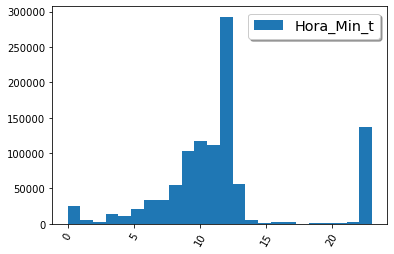

Hora_Max_t
                       Valor
Máximo               23.0000
Mínomo                0.0000
Media                10.0040
Mediana              12.0000
Desviación Estándar   8.0025
Asimetría             0.2494


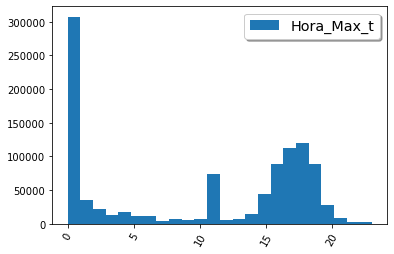

In [18]:
graficar_densidades(Pichilemu)

Se procece a invocar función "Inf_Gain" para obtener la ganancia de información de las variables de la base de datos. Debemos recordar que la información se está obteniendo a través de un sample de 20 mil registros de los datos, un delta (tiempo de desfase) de 40 minutos entre la lectura de los datos y su respuesta, y considerando un límite de 7 grados como temperatura baja. 

In [19]:
IG=Inf_Gain(Pichilemu,Pichilemu.drop(columns=['momento']))
IG

                                          IG
Anno                                0.176861
rrInst                              0.647190
Mes                                 0.823046
Hora_Max_t                          1.768179
Hora                                1.828211
Hora_Min_t                          2.227393
Dia                                 2.628218
Minuto                              5.686001
tMax12Horas                        13.588960
tMin12Horas                        15.735805
rr6Horas                           23.463395
ts                                 23.547167
ff10Minutos                        30.627736
ff02Minutos                        34.734467
td                                 35.902172
rr24Horas                          38.373462
ffInst                             41.565669
qff                                44.522029
qnh                                45.807036
qfe1                               45.817470
p0                                 47.646612
radiacionG

Se procece a invocar función "Inf_Value" para obtener el valor de información de las variables de la base de datos. Debemos recordar que la información se está obteniendo a través de un sample de 20 mil registros de los datos, un delta (tiempo de desfase) de 40 minutos entre la lectura de los datos y su respuesta, y considerando un límite de 7 grados como temperatura baja. 

In [20]:
IV=Inf_Value(Pichilemu,Pichilemu.drop(columns=['momento']))
IV

                                          IV
Anno                                1.252635
rrInst                              1.490803
Mes                                 7.569547
Hora_Min_t                         13.993674
Hora                               15.063371
Hora_Max_t                         15.417079
Dia                                19.407002
rr6Horas                           27.214622
Minuto                             37.425657
rr24Horas                          48.413436
tMin12Horas                        82.106463
tMax12Horas                        83.126141
td                                 89.128723
ts                                102.882987
qff                               120.495625
qfe1                              120.546531
qnh                               121.310728
p0                                122.765981
ff10Minutos                       122.892095
ff02Minutos                       127.874355
ffInst                            134.310081
hr        

Dados los resultados anteriores de IG e IV, se determina que las Variables de poco IG e IV son:
Anno; Mes; rrInst; Hora; Dia; Hora_Max_t; Hora_Min_t; Minuto; tMax12Horas; tMin12Horas

Se procede a generar Árbol de Decisión

In [21]:
Arbol(Pichilemu,Pichilemu.drop(columns=['momento']))

ACCURACY:
0.9891585374502737


[DecisionTreeClassifier(max_depth=5),
         0     1
 0  301029  1488
 1    1875  5806]

Se puede apreciar que los resultados del árbol de decisión indican un Accuracy del 98,92%

A continuación se procede a ejecutar función "BackWard_Logit"

Optimization terminated successfully.
         Current function value: 0.021505
         Iterations 14


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
================================================================================
Model:                   Logit                 Pseudo R-squared:      0.810     
Dependent Variable:      ts                    AIC:                   31184.8518
Date:                    2020-07-02 00:34      BIC:                   31495.1430
No. Observations:        723797                Log-Likelihood:        -15565.   
Df Model:                26                    LL-Null:               -81861.   
Df Residuals:            723770                LLR p-value:           0.0000    
Converged:               1.0000                Scale:                 1.0000    
No. Iterations:          14.0000                                                
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
rrInst                           5.8978   1.5372   3.8367 0.0001  2.8849  8.9106
rr6Horas                         0.0480   0.0313   1.5329 0.1253 -0.0134  0.1093
rr24Horas                        0.0374   0.0068   5.5031 0.0000  0.0241  0.0507
hr                               0.0761   0.0177   4.3107 0.0000  0.0415  0.1107
p0                               0.0075   0.0068   1.0971 0.2726 -0.0059  0.0208
qfe1                             0.7719   0.4042   1.9096 0.0562 -0.0203  1.5641
qff                             -0.9771   0.4826  -2.0245 0.0429 -1.9230 -0.0311
qnh                              0.2450   0.5213   0.4701 0.6383 -0.7767  1.2668
radiacionGlobalInst             -0.0182   0.0007 -26.1760 0.0000 -0.0195 -0.0168
radiacionGlobalAcumulada24Horas  0.0012   0.0003   4.8123 0.0000  0.0007  0.0017
ddInst                          -0.0010   0.0004  -2.2877 0.0222 -0.0018 -0.0001
ffInst                          -0.0131   0.0229  -0.5716 0.5676 -0.0581  0.0318
dd02Minutos                     -0.0003   0.0004  -0.6504 0.5154 -0.0011  0.0005
ff02Minutos                     -0.1290   0.0264  -4.8806 0.0000 -0.1807 -0.0772
dd10Minutos                      0.0011   0.0003   3.3698 0.0008  0.0004  0.0017
ff10Minutos                      0.2533   0.0147  17.2158 0.0000  0.2244  0.2821
ts                              -1.6565   0.0930 -17.8176 0.0000 -1.8387 -1.4743
td                              -0.5209   0.0937  -5.5569 0.0000 -0.7046 -0.3372
tMin12Horas                     -0.1131   0.0129  -8.7903 0.0000 -0.1383 -0.0879
tMax12Horas                     -0.0443   0.0149  -2.9671 0.0030 -0.0735 -0.0150
Anno                            -0.0190   0.0028  -6.8494 0.0000 -0.0245 -0.0136
Mes                             -0.0383   0.0150  -2.5562 0.0106 -0.0676 -0.0089
Dia                              0.0047   0.0018   2.5995 0.0093  0.0012  0.0083
Hora                             0.0005   0.0051   0.0920 0.9267 -0.0095  0.0105
Minuto                          -0.0001   0.0008  -0.0657 0.9476 -0.0017  0.0016
Hora_Min_t                      -0.0279   0.0049  -5.7437 0.0000 -0.0375 -0.0184
Hora_Max_t                       0.0967   0.0047  20.4402 0.0000  0.0875  0.1060
================================================================================

"""

{'gini': 0.9745195004481009, 'entropy': 0.9795066376959233}
Confusion Matrix :
        0     1
0  301299  1218
1    1920  5761
Accuracy Score : 0.9898838806181858
Report : 
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    302517
         1.0       0.83      0.75      0.79      7681

    accuracy                           0.99    310198
   macro avg       0.91      0.87      0.89    310198
weighted avg       0.99      0.99      0.99    310198

ROC_AUC_score:
0.9960237527192309


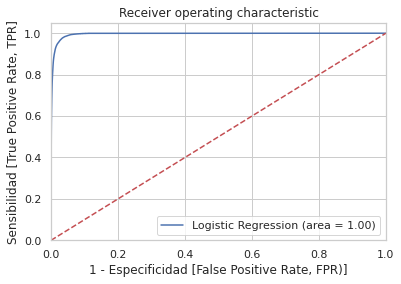

0.9476
25    Minuto
Name: Predictor, dtype: object
Optimization terminated successfully.
         Current function value: 0.021505
         Iterations 14


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
================================================================================
Model:                   Logit                 Pseudo R-squared:      0.810     
Dependent Variable:      ts                    AIC:                   31182.8561
Date:                    2020-07-02 00:35      BIC:                   31481.6551
No. Observations:        723797                Log-Likelihood:        -15565.   
Df Model:                25                    LL-Null:               -81861.   
Df Residuals:            723771                LLR p-value:           0.0000    
Converged:               1.0000                Scale:                 1.0000    
No. Iterations:          14.0000                                                
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
rrInst                           5.8977   1.5370   3.8373 0.0001  2.8853  8.9101
rr6Horas                         0.0479   0.0313   1.5319 0.1255 -0.0134  0.1092
rr24Horas                        0.0374   0.0068   5.5048 0.0000  0.0241  0.0507
hr                               0.0761   0.0177   4.3117 0.0000  0.0415  0.1107
p0                               0.0075   0.0068   1.1000 0.2713 -0.0058  0.0208
qfe1                             0.7719   0.4042   1.9097 0.0562 -0.0203  1.5641
qff                             -0.9772   0.4826  -2.0247 0.0429 -1.9231 -0.0312
qnh                              0.2451   0.5213   0.4702 0.6382 -0.7766  1.2669
radiacionGlobalInst             -0.0182   0.0007 -26.2073 0.0000 -0.0195 -0.0168
radiacionGlobalAcumulada24Horas  0.0012   0.0003   4.8141 0.0000  0.0007  0.0017
ddInst                          -0.0010   0.0004  -2.2880 0.0221 -0.0018 -0.0001
ffInst                          -0.0131   0.0229  -0.5715 0.5676 -0.0580  0.0318
dd02Minutos                     -0.0003   0.0004  -0.6494 0.5161 -0.0011  0.0005
ff02Minutos                     -0.1290   0.0264  -4.8817 0.0000 -0.1808 -0.0772
dd10Minutos                      0.0011   0.0003   3.3706 0.0007  0.0004  0.0017
ff10Minutos                      0.2533   0.0147  17.2168 0.0000  0.2244  0.2821
ts                              -1.6564   0.0930 -17.8182 0.0000 -1.8386 -1.4742
td                              -0.5209   0.0937  -5.5578 0.0000 -0.7047 -0.3372
tMin12Horas                     -0.1131   0.0129  -8.7921 0.0000 -0.1383 -0.0879
tMax12Horas                     -0.0443   0.0149  -2.9692 0.0030 -0.0735 -0.0151
Anno                            -0.0190   0.0028  -6.8505 0.0000 -0.0245 -0.0136
Mes                             -0.0383   0.0150  -2.5573 0.0105 -0.0676 -0.0089
Dia                              0.0047   0.0018   2.5990 0.0093  0.0012  0.0083
Hora                             0.0005   0.0051   0.0942 0.9249 -0.0095  0.0105
Hora_Min_t                      -0.0279   0.0049  -5.7435 0.0000 -0.0375 -0.0184
Hora_Max_t                       0.0967   0.0047  20.4511 0.0000  0.0875  0.1060
================================================================================

"""

{'gini': 0.9749933913178035, 'entropy': 0.9788909019400512}
Confusion Matrix :
        0     1
0  301299  1218
1    1919  5762
Accuracy Score : 0.9898871043655988
Report : 
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    302517
         1.0       0.83      0.75      0.79      7681

    accuracy                           0.99    310198
   macro avg       0.91      0.87      0.89    310198
weighted avg       0.99      0.99      0.99    310198

ROC_AUC_score:
0.9960238095653106


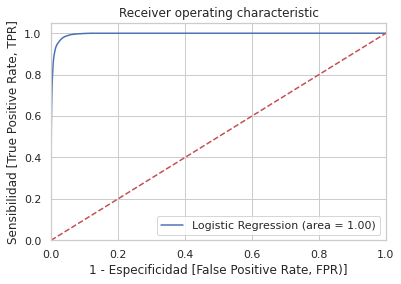

0.9249
24    Hora
Name: Predictor, dtype: object
Optimization terminated successfully.
         Current function value: 0.021505
         Iterations 14


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
================================================================================
Model:                   Logit                 Pseudo R-squared:      0.810     
Dependent Variable:      ts                    AIC:                   31180.8650
Date:                    2020-07-02 00:36      BIC:                   31468.1717
No. Observations:        723797                Log-Likelihood:        -15565.   
Df Model:                24                    LL-Null:               -81861.   
Df Residuals:            723772                LLR p-value:           0.0000    
Converged:               1.0000                Scale:                 1.0000    
No. Iterations:          14.0000                                                
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
rrInst                           5.8998   1.5363   3.8401 0.0001  2.8886  8.9110
rr6Horas                         0.0483   0.0311   1.5524 0.1206 -0.0127  0.1092
rr24Horas                        0.0373   0.0067   5.5492 0.0000  0.0241  0.0505
hr                               0.0761   0.0176   4.3109 0.0000  0.0415  0.1106
p0                               0.0075   0.0068   1.1009 0.2709 -0.0058  0.0208
qfe1                             0.7713   0.4041   1.9084 0.0563 -0.0209  1.5634
qff                             -0.9766   0.4826  -2.0236 0.0430 -1.9224 -0.0307
qnh                              0.2450   0.5213   0.4700 0.6383 -0.7767  1.2668
radiacionGlobalInst             -0.0182   0.0007 -26.2107 0.0000 -0.0195 -0.0168
radiacionGlobalAcumulada24Horas  0.0012   0.0003   4.8441 0.0000  0.0007  0.0017
ddInst                          -0.0010   0.0004  -2.2870 0.0222 -0.0018 -0.0001
ffInst                          -0.0131   0.0229  -0.5715 0.5677 -0.0580  0.0318
dd02Minutos                     -0.0003   0.0004  -0.6504 0.5154 -0.0011  0.0005
ff02Minutos                     -0.1290   0.0264  -4.8814 0.0000 -0.1808 -0.0772
dd10Minutos                      0.0011   0.0003   3.3697 0.0008  0.0004  0.0017
ff10Minutos                      0.2533   0.0147  17.2413 0.0000  0.2245  0.2821
ts                              -1.6569   0.0928 -17.8501 0.0000 -1.8388 -1.4749
td                              -0.5208   0.0937  -5.5572 0.0000 -0.7045 -0.3371
tMin12Horas                     -0.1127   0.0123  -9.1733 0.0000 -0.1368 -0.0887
tMax12Horas                     -0.0444   0.0149  -2.9753 0.0029 -0.0736 -0.0151
Anno                            -0.0190   0.0027  -6.9893 0.0000 -0.0243 -0.0137
Mes                             -0.0381   0.0149  -2.5600 0.0105 -0.0673 -0.0089
Dia                              0.0047   0.0018   2.6097 0.0091  0.0012  0.0083
Hora_Min_t                      -0.0280   0.0048  -5.7723 0.0000 -0.0375 -0.0185
Hora_Max_t                       0.0965   0.0042  22.7964 0.0000  0.0882  0.1048
================================================================================

"""

{'gini': 0.9741971257068066, 'entropy': 0.9747677289988975}
Confusion Matrix :
        0     1
0  301299  1218
1    1920  5761
Accuracy Score : 0.9898838806181858
Report : 
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    302517
         1.0       0.83      0.75      0.79      7681

    accuracy                           0.99    310198
   macro avg       0.91      0.87      0.89    310198
weighted avg       0.99      0.99      0.99    310198

ROC_AUC_score:
0.9960234620736013


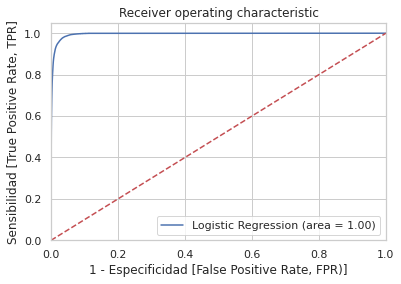

0.6383
8    qnh
Name: Predictor, dtype: object
Optimization terminated successfully.
         Current function value: 0.021505
         Iterations 14


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
================================================================================
Model:                   Logit                 Pseudo R-squared:      0.810     
Dependent Variable:      ts                    AIC:                   31179.0856
Date:                    2020-07-02 00:36      BIC:                   31454.9000
No. Observations:        723797                Log-Likelihood:        -15566.   
Df Model:                23                    LL-Null:               -81861.   
Df Residuals:            723773                LLR p-value:           0.0000    
Converged:               1.0000                Scale:                 1.0000    
No. Iterations:          14.0000                                                
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
rrInst                           5.9000   1.5375   3.8374 0.0001  2.8865  8.9134
rr6Horas                         0.0482   0.0311   1.5513 0.1208 -0.0127  0.1092
rr24Horas                        0.0373   0.0067   5.5508 0.0000  0.0241  0.0505
hr                               0.0760   0.0176   4.3098 0.0000  0.0415  0.1106
p0                               0.0075   0.0068   1.1020 0.2705 -0.0058  0.0208
qfe1                             0.8620   0.3551   2.4273 0.0152  0.1660  1.5580
qff                             -0.8222   0.3538  -2.3235 0.0202 -1.5157 -0.1286
radiacionGlobalInst             -0.0182   0.0007 -26.2100 0.0000 -0.0195 -0.0168
radiacionGlobalAcumulada24Horas  0.0012   0.0003   4.8460 0.0000  0.0007  0.0017
ddInst                          -0.0010   0.0004  -2.2847 0.0223 -0.0018 -0.0001
ffInst                          -0.0131   0.0229  -0.5722 0.5672 -0.0581  0.0318
dd02Minutos                     -0.0003   0.0004  -0.6523 0.5142 -0.0011  0.0005
ff02Minutos                     -0.1291   0.0264  -4.8845 0.0000 -0.1808 -0.0773
dd10Minutos                      0.0011   0.0003   3.3721 0.0007  0.0004  0.0017
ff10Minutos                      0.2534   0.0147  17.2464 0.0000  0.2246  0.2822
ts                              -1.6549   0.0927 -17.8472 0.0000 -1.8366 -1.4732
td                              -0.5207   0.0937  -5.5559 0.0000 -0.7044 -0.3370
tMin12Horas                     -0.1127   0.0123  -9.1712 0.0000 -0.1368 -0.0886
tMax12Horas                     -0.0444   0.0149  -2.9799 0.0029 -0.0736 -0.0152
Anno                            -0.0189   0.0027  -6.9738 0.0000 -0.0242 -0.0136
Mes                             -0.0381   0.0149  -2.5584 0.0105 -0.0673 -0.0089
Dia                              0.0047   0.0018   2.6083 0.0091  0.0012  0.0083
Hora_Min_t                      -0.0280   0.0048  -5.7725 0.0000 -0.0375 -0.0185
Hora_Max_t                       0.0965   0.0042  22.7986 0.0000  0.0882  0.1048
================================================================================

"""

{'gini': 0.9723112334702352, 'entropy': 0.9793744640519926}
Confusion Matrix :
        0     1
0  301298  1219
1    1922  5759
Accuracy Score : 0.989874209375947
Report : 
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    302517
         1.0       0.83      0.75      0.79      7681

    accuracy                           0.99    310198
   macro avg       0.91      0.87      0.89    310198
weighted avg       0.99      0.99      0.99    310198

ROC_AUC_score:
0.9960233342045726


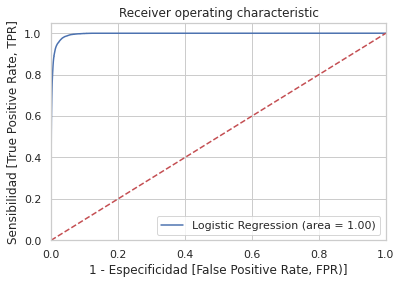

0.5672
11    ffInst
Name: Predictor, dtype: object
Optimization terminated successfully.
         Current function value: 0.021506
         Iterations 14


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
================================================================================
Model:                   Logit                 Pseudo R-squared:      0.810     
Dependent Variable:      ts                    AIC:                   31177.4132
Date:                    2020-07-02 00:37      BIC:                   31441.7353
No. Observations:        723797                Log-Likelihood:        -15566.   
Df Model:                22                    LL-Null:               -81861.   
Df Residuals:            723774                LLR p-value:           0.0000    
Converged:               1.0000                Scale:                 1.0000    
No. Iterations:          14.0000                                                
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
rrInst                           5.9033   1.5456   3.8193 0.0001  2.8739  8.9326
rr6Horas                         0.0483   0.0311   1.5554 0.1198 -0.0126  0.1093
rr24Horas                        0.0373   0.0067   5.5491 0.0000  0.0241  0.0505
hr                               0.0761   0.0176   4.3122 0.0000  0.0415  0.1107
p0                               0.0075   0.0068   1.0982 0.2721 -0.0059  0.0208
qfe1                             0.8623   0.3551   2.4281 0.0152  0.1663  1.5583
qff                             -0.8224   0.3538  -2.3242 0.0201 -1.5159 -0.1289
radiacionGlobalInst             -0.0182   0.0007 -26.2102 0.0000 -0.0195 -0.0168
radiacionGlobalAcumulada24Horas  0.0012   0.0003   4.8509 0.0000  0.0007  0.0017
ddInst                          -0.0010   0.0004  -2.2800 0.0226 -0.0018 -0.0001
dd02Minutos                     -0.0003   0.0004  -0.6560 0.5118 -0.0011  0.0005
ff02Minutos                     -0.1420   0.0137 -10.3546 0.0000 -0.1689 -0.1151
dd10Minutos                      0.0011   0.0003   3.3702 0.0008  0.0004  0.0017
ff10Minutos                      0.2533   0.0147  17.2406 0.0000  0.2245  0.2821
ts                              -1.6547   0.0927 -17.8460 0.0000 -1.8364 -1.4729
td                              -0.5209   0.0937  -5.5583 0.0000 -0.7045 -0.3372
tMin12Horas                     -0.1127   0.0123  -9.1692 0.0000 -0.1368 -0.0886
tMax12Horas                     -0.0445   0.0149  -2.9849 0.0028 -0.0737 -0.0153
Anno                            -0.0189   0.0027  -6.9751 0.0000 -0.0242 -0.0136
Mes                             -0.0382   0.0149  -2.5670 0.0103 -0.0674 -0.0090
Dia                              0.0047   0.0018   2.6068 0.0091  0.0012  0.0083
Hora_Min_t                      -0.0280   0.0048  -5.7723 0.0000 -0.0375 -0.0185
Hora_Max_t                       0.0965   0.0042  22.8018 0.0000  0.0883  0.1048
================================================================================

"""

{'gini': 0.9755124146512872, 'entropy': 0.9790262993313947}
Confusion Matrix :
        0     1
0  301296  1221
1    1923  5758
Accuracy Score : 0.9898645381337081
Report : 
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    302517
         1.0       0.83      0.75      0.79      7681

    accuracy                           0.99    310198
   macro avg       0.91      0.87      0.89    310198
weighted avg       0.99      0.99      0.99    310198

ROC_AUC_score:
0.9960232854171326


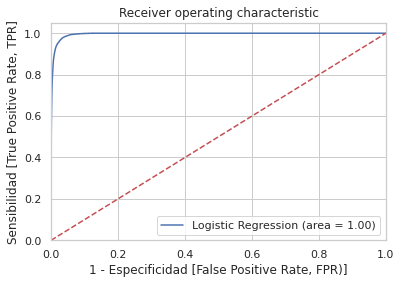

0.5118
11    dd02Minutos
Name: Predictor, dtype: object
Optimization terminated successfully.
         Current function value: 0.021506
         Iterations 14


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
================================================================================
Model:                   Logit                 Pseudo R-squared:      0.810     
Dependent Variable:      ts                    AIC:                   31175.8431
Date:                    2020-07-02 00:38      BIC:                   31428.6729
No. Observations:        723797                Log-Likelihood:        -15566.   
Df Model:                21                    LL-Null:               -81861.   
Df Residuals:            723775                LLR p-value:           0.0000    
Converged:               1.0000                Scale:                 1.0000    
No. Iterations:          14.0000                                                
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
rrInst                           5.8884   1.5351   3.8359 0.0001  2.8797  8.8971
rr6Horas                         0.0479   0.0311   1.5429 0.1229 -0.0130  0.1088
rr24Horas                        0.0374   0.0067   5.5664 0.0000  0.0242  0.0505
hr                               0.0765   0.0176   4.3402 0.0000  0.0420  0.1111
p0                               0.0075   0.0068   1.0990 0.2718 -0.0058  0.0208
qfe1                             0.8616   0.3551   2.4261 0.0153  0.1655  1.5576
qff                             -0.8218   0.3538  -2.3225 0.0202 -1.5153 -0.1283
radiacionGlobalInst             -0.0182   0.0007 -26.2105 0.0000 -0.0195 -0.0168
radiacionGlobalAcumulada24Horas  0.0012   0.0003   4.8527 0.0000  0.0007  0.0017
ddInst                          -0.0012   0.0003  -3.8209 0.0001 -0.0017 -0.0006
ff02Minutos                     -0.1428   0.0137 -10.4623 0.0000 -0.1696 -0.1161
dd10Minutos                      0.0010   0.0003   3.3053 0.0009  0.0004  0.0016
ff10Minutos                      0.2532   0.0147  17.2332 0.0000  0.2244  0.2820
ts                              -1.6528   0.0927 -17.8350 0.0000 -1.8344 -1.4712
td                              -0.5228   0.0937  -5.5822 0.0000 -0.7064 -0.3393
tMin12Horas                     -0.1127   0.0123  -9.1716 0.0000 -0.1368 -0.0886
tMax12Horas                     -0.0447   0.0149  -2.9959 0.0027 -0.0739 -0.0154
Anno                            -0.0189   0.0027  -6.9676 0.0000 -0.0242 -0.0136
Mes                             -0.0379   0.0149  -2.5484 0.0108 -0.0671 -0.0088
Dia                              0.0047   0.0018   2.5973 0.0094  0.0012  0.0083
Hora_Min_t                      -0.0280   0.0048  -5.7738 0.0000 -0.0375 -0.0185
Hora_Max_t                       0.0966   0.0042  22.8019 0.0000  0.0883  0.1049
================================================================================

"""

{'gini': 0.9714279266790888, 'entropy': 0.9790456418158724}
Confusion Matrix :
        0     1
0  301193  1324
1    1822  5859
Accuracy Score : 0.9898580906388823
Report : 
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    302517
         1.0       0.82      0.76      0.79      7681

    accuracy                           0.99    310198
   macro avg       0.90      0.88      0.89    310198
weighted avg       0.99      0.99      0.99    310198

ROC_AUC_score:
0.9960236129107434


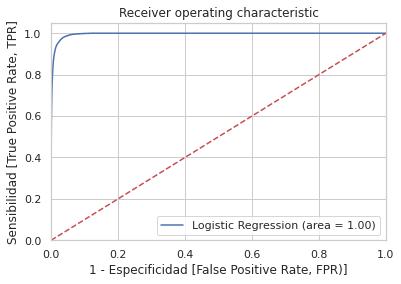

0.2718
5    p0
Name: Predictor, dtype: object
Optimization terminated successfully.
         Current function value: 0.021507
         Iterations 14


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
================================================================================
Model:                   Logit                 Pseudo R-squared:      0.810     
Dependent Variable:      ts                    AIC:                   31175.1181
Date:                    2020-07-02 00:39      BIC:                   31416.4557
No. Observations:        723797                Log-Likelihood:        -15567.   
Df Model:                20                    LL-Null:               -81861.   
Df Residuals:            723776                LLR p-value:           0.0000    
Converged:               1.0000                Scale:                 1.0000    
No. Iterations:          14.0000                                                
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
rrInst                           5.8917   1.5347   3.8390 0.0001  2.8838  8.8995
rr6Horas                         0.0480   0.0311   1.5447 0.1224 -0.0129  0.1088
rr24Horas                        0.0374   0.0067   5.5653 0.0000  0.0242  0.0505
hr                               0.0764   0.0176   4.3338 0.0000  0.0418  0.1109
qfe1                             0.8655   0.3551   2.4372 0.0148  0.1695  1.5615
qff                             -0.8182   0.3538  -2.3124 0.0208 -1.5117 -0.1247
radiacionGlobalInst             -0.0182   0.0007 -26.2434 0.0000 -0.0196 -0.0168
radiacionGlobalAcumulada24Horas  0.0012   0.0003   4.8538 0.0000  0.0007  0.0017
ddInst                          -0.0012   0.0003  -3.8178 0.0001 -0.0017 -0.0006
ff02Minutos                     -0.1429   0.0136 -10.4728 0.0000 -0.1697 -0.1162
dd10Minutos                      0.0010   0.0003   3.3088 0.0009  0.0004  0.0016
ff10Minutos                      0.2533   0.0147  17.2462 0.0000  0.2245  0.2821
ts                              -1.6533   0.0927 -17.8415 0.0000 -1.8349 -1.4717
td                              -0.5221   0.0937  -5.5750 0.0000 -0.7057 -0.3386
tMin12Horas                     -0.1127   0.0123  -9.1733 0.0000 -0.1368 -0.0887
tMax12Horas                     -0.0445   0.0149  -2.9883 0.0028 -0.0738 -0.0153
Anno                            -0.0189   0.0027  -6.9709 0.0000 -0.0242 -0.0136
Mes                             -0.0379   0.0149  -2.5468 0.0109 -0.0671 -0.0087
Dia                              0.0047   0.0018   2.6052 0.0092  0.0012  0.0083
Hora_Min_t                      -0.0279   0.0048  -5.7689 0.0000 -0.0374 -0.0185
Hora_Max_t                       0.0967   0.0042  22.8438 0.0000  0.0884  0.1050
================================================================================

"""

{'gini': 0.971701945209189, 'entropy': 0.9784073398281098}
Confusion Matrix :
        0     1
0  301193  1324
1    1820  5861
Accuracy Score : 0.9898645381337081
Report : 
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    302517
         1.0       0.82      0.76      0.79      7681

    accuracy                           0.99    310198
   macro avg       0.90      0.88      0.89    310198
weighted avg       0.99      0.99      0.99    310198

ROC_AUC_score:
0.9960227135111195


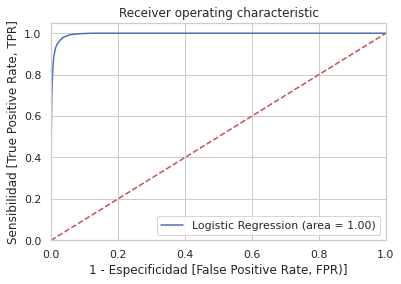

0.1224
2    rr6Horas
Name: Predictor, dtype: object
Optimization terminated successfully.
         Current function value: 0.021508
         Iterations 14


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
================================================================================
Model:                   Logit                 Pseudo R-squared:      0.810     
Dependent Variable:      ts                    AIC:                   31175.5173
Date:                    2020-07-02 00:39      BIC:                   31405.3626
No. Observations:        723797                Log-Likelihood:        -15568.   
Df Model:                19                    LL-Null:               -81861.   
Df Residuals:            723777                LLR p-value:           0.0000    
Converged:               1.0000                Scale:                 1.0000    
No. Iterations:          14.0000                                                
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
rrInst                           6.1898   1.4725   4.2035 0.0000  3.3037  9.0759
rr24Horas                        0.0452   0.0044  10.2818 0.0000  0.0366  0.0538
hr                               0.0781   0.0176   4.4418 0.0000  0.0436  0.1126
qfe1                             0.8693   0.3551   2.4478 0.0144  0.1733  1.5653
qff                             -0.8213   0.3539  -2.3210 0.0203 -1.5148 -0.1277
radiacionGlobalInst             -0.0182   0.0007 -26.2203 0.0000 -0.0195 -0.0168
radiacionGlobalAcumulada24Horas  0.0012   0.0003   4.9251 0.0000  0.0007  0.0017
ddInst                          -0.0011   0.0003  -3.7940 0.0001 -0.0017 -0.0006
ff02Minutos                     -0.1435   0.0136 -10.5195 0.0000 -0.1703 -0.1168
dd10Minutos                      0.0010   0.0003   3.3282 0.0009  0.0004  0.0016
ff10Minutos                      0.2529   0.0147  17.2187 0.0000  0.2241  0.2817
ts                              -1.6449   0.0924 -17.7940 0.0000 -1.8261 -1.4637
td                              -0.5308   0.0934  -5.6814 0.0000 -0.7139 -0.3477
tMin12Horas                     -0.1124   0.0123  -9.1362 0.0000 -0.1365 -0.0882
tMax12Horas                     -0.0455   0.0149  -3.0503 0.0023 -0.0747 -0.0163
Anno                            -0.0193   0.0027  -7.1662 0.0000 -0.0246 -0.0140
Mes                             -0.0388   0.0149  -2.6051 0.0092 -0.0680 -0.0096
Dia                              0.0046   0.0018   2.5483 0.0108  0.0011  0.0082
Hora_Min_t                      -0.0287   0.0048  -5.9597 0.0000 -0.0382 -0.0193
Hora_Max_t                       0.0970   0.0042  22.9004 0.0000  0.0887  0.1053
================================================================================

"""

{'gini': 0.9734073075906357, 'entropy': 0.9797419712570681}
Confusion Matrix :
        0     1
0  301243  1274
1    1875  5806
Accuracy Score : 0.9898484193966435
Report : 
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    302517
         1.0       0.82      0.76      0.79      7681

    accuracy                           0.99    310198
   macro avg       0.91      0.88      0.89    310198
weighted avg       0.99      0.99      0.99    310198

ROC_AUC_score:
0.9960215339401179


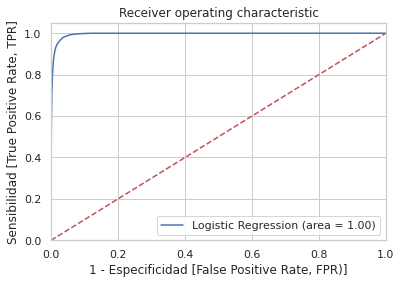

0.0203
5    qff
Name: Predictor, dtype: object
Seleccion Backward:
1                              rrInst
2                           rr24Horas
3                                  hr
4                                qfe1
5                                 qff
6                 radiacionGlobalInst
7     radiacionGlobalAcumulada24Horas
8                              ddInst
9                         ff02Minutos
10                        dd10Minutos
11                        ff10Minutos
12                                 ts
13                                 td
14                        tMin12Horas
15                        tMax12Horas
16                               Anno
17                                Mes
18                                Dia
19                         Hora_Min_t
20                         Hora_Max_t
Name: Predictor, dtype: object


In [22]:
Backward_Logit(Pichilemu,Pichilemu.drop(columns=['momento']))

Se puede apreciar que los resultados del BackWard_Logit indican un accuracy del 98,98% y una matriz de confusión más desbalanceada que el árbol.

A continuación se procede a ejecutar función "Forward"

formula : ts2 ~ Anno + 1
formula : ts2 ~ qfe1 + 1
formula : ts2 ~ ts + 1
formula : ts2 ~ rr6Horas + 1
formula : ts2 ~ radiacionGlobalInst + 1
formula : ts2 ~ qnh + 1
formula : ts2 ~ p0 + 1
formula : ts2 ~ rrInst + 1
formula : ts2 ~ tMin12Horas + 1
formula : ts2 ~ Hora_Min_t + 1
formula : ts2 ~ dd02Minutos + 1
formula : ts2 ~ rr24Horas + 1
formula : ts2 ~ Hora + 1
formula : ts2 ~ qff + 1
formula : ts2 ~ dd10Minutos + 1
formula : ts2 ~ tMax12Horas + 1
formula : ts2 ~ radiacionGlobalAcumulada24Horas + 1
formula : ts2 ~ td + 1
formula : ts2 ~ ddInst + 1
formula : ts2 ~ ff10Minutos + 1
formula : ts2 ~ Minuto + 1
formula : ts2 ~ Hora_Max_t + 1
formula : ts2 ~ ff02Minutos + 1
formula : ts2 ~ ffInst + 1
formula : ts2 ~ hr + 1
formula : ts2 ~ Mes + 1
formula : ts2 ~ Dia + 1
formula : ts2 ~ td + Anno + 1
formula : ts2 ~ td + qfe1 + 1
formula : ts2 ~ td + ts + 1
formula : ts2 ~ td + rr6Horas + 1
formula : ts2 ~ td + radiacionGlobalInst + 1
formula : ts2 ~ td + qnh + 1
formula : ts2 ~ td + p0 + 1


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
================================================================================
Model:                   Logit                 Pseudo R-squared:      0.810     
Dependent Variable:      ts                    AIC:                   31185.6730
Date:                    2020-07-02 00:48      BIC:                   31461.4874
No. Observations:        723797                Log-Likelihood:        -15569.   
Df Model:                23                    LL-Null:               -81861.   
Df Residuals:            723773                LLR p-value:           0.0000    
Converged:               1.0000                Scale:                 1.0000    
No. Iterations:          14.0000                                                
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
rrInst                           5.9379   1.5768   3.7658 0.0002  2.8475  9.0284
rr6Horas                         0.0485   0.0314   1.5469 0.1219 -0.0130  0.1100
rr24Horas                        0.0375   0.0068   5.5153 0.0000  0.0242  0.0508
hr                               0.0756   0.0177   4.2821 0.0000  0.0410  0.1103
qfe1                             0.7810   0.4041   1.9327 0.0533 -0.0110  1.5731
qff                             -0.9745   0.4826  -2.0193 0.0435 -1.9203 -0.0287
qnh                              0.2408   0.5212   0.4620 0.6441 -0.7808  1.2624
radiacionGlobalInst             -0.0182   0.0007 -26.2517 0.0000 -0.0196 -0.0169
radiacionGlobalAcumulada24Horas  0.0012   0.0003   4.8973 0.0000  0.0007  0.0017
dd02Minutos                     -0.0009   0.0003  -3.1343 0.0017 -0.0015 -0.0003
ff02Minutos                     -0.1387   0.0136 -10.1710 0.0000 -0.1655 -0.1120
dd10Minutos                      0.0009   0.0003   2.9364 0.0033  0.0003  0.0015
ff10Minutos                      0.2519   0.0147  17.1457 0.0000  0.2231  0.2807
ts                              -1.6592   0.0930 -17.8353 0.0000 -1.8415 -1.4768
td                              -0.5171   0.0938  -5.5135 0.0000 -0.7009 -0.3333
tMin12Horas                     -0.1135   0.0129  -8.8255 0.0000 -0.1387 -0.0883
tMax12Horas                     -0.0452   0.0149  -3.0285 0.0025 -0.0744 -0.0159
Anno                            -0.0191   0.0028  -6.8576 0.0000 -0.0245 -0.0136
Mes                             -0.0410   0.0149  -2.7481 0.0060 -0.0702 -0.0118
Dia                              0.0048   0.0018   2.6247 0.0087  0.0012  0.0084
Hora                             0.0004   0.0051   0.0728 0.9420 -0.0096  0.0104
Minuto                          -0.0001   0.0008  -0.1139 0.9093 -0.0018  0.0016
Hora_Min_t                      -0.0277   0.0049  -5.6899 0.0000 -0.0372 -0.0181
Hora_Max_t                       0.0970   0.0047  20.5154 0.0000  0.0877  0.1063
================================================================================

"""

{'gini': 0.9704350124759025, 'entropy': 0.9763086802622841}
Confusion Matrix :
        0     1
0  301197  1320
1    1820  5861
Accuracy Score : 0.98987743312336
Report : 
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    302517
         1.0       0.82      0.76      0.79      7681

    accuracy                           0.99    310198
   macro avg       0.91      0.88      0.89    310198
weighted avg       0.99      0.99      0.99    310198

ROC_AUC_score:
0.9960246676025308


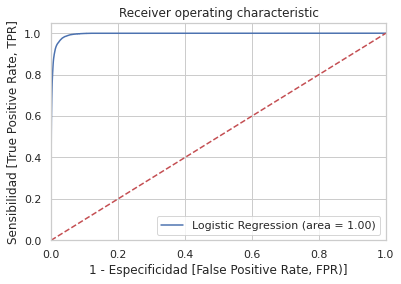

In [23]:
Forward(Pichilemu,Pichilemu.drop(columns=['momento']))

A continuación se procede a realizar un análisis de componentes principales de la matriz

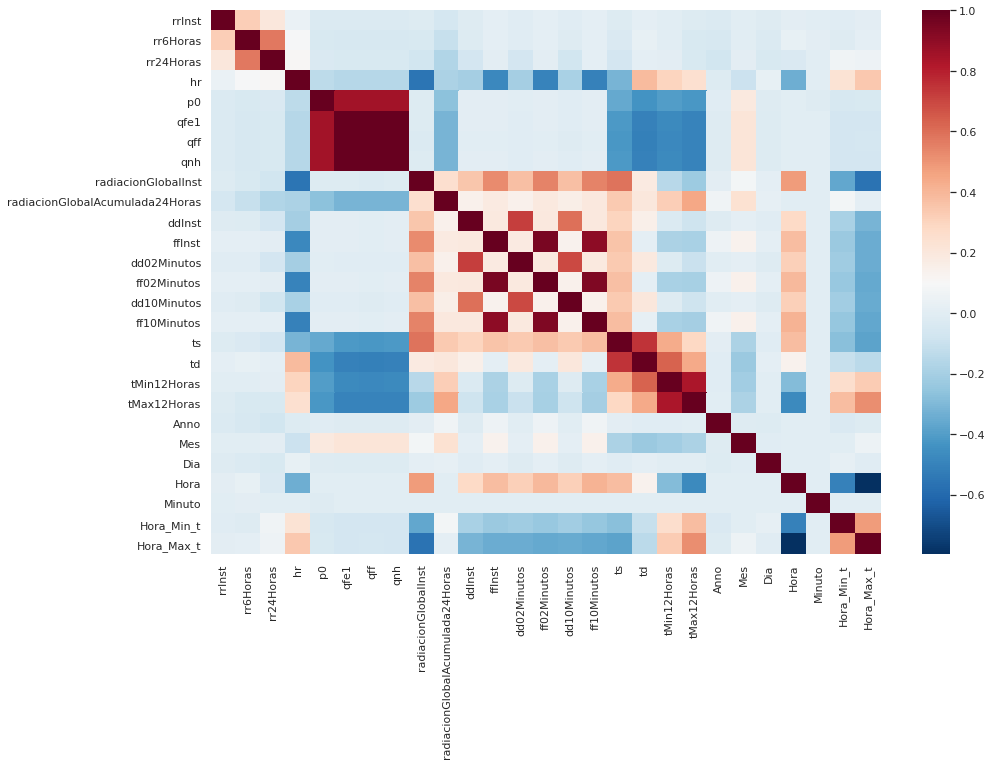

[0.20917886 0.20096993 0.08141577 0.07278904 0.06009594 0.04611596
 0.03788159 0.03704456 0.03636136 0.03564633 0.03171312 0.02931015
 0.0217088  0.01788216 0.01482408 0.01444532 0.01341157 0.00916716
 0.00780516]
[0.20917886 0.41014879 0.49156455 0.56435359 0.62444954 0.6705655
 0.70844709 0.74549165 0.78185301 0.81749933 0.84921245 0.87852261
 0.90023141 0.91811357 0.93293765 0.94738297 0.96079454 0.9699617
 0.97776686]


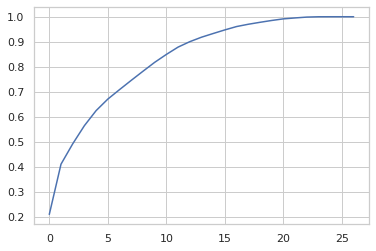

[[-3.15199817e+00  1.40670599e+00 -6.90405500e-01 ... -5.21374415e-03
  -7.74866386e-04  6.84535126e-05]
 [-3.04757391e+00  1.44949186e+00 -4.01568984e-01 ... -9.62035572e-03
  -7.95582600e-04  7.33655038e-05]
 [-3.11301246e+00  1.44397084e+00 -5.93103416e-01 ...  1.54621917e-02
  -5.07241291e-04  7.44846499e-05]
 ...
 [ 1.65338018e-01  3.09794439e+00 -1.23358884e+00 ... -1.48438791e-02
   3.34808987e-03 -4.91730984e-04]
 [ 3.34264338e-02  3.01646003e+00 -1.14471631e+00 ...  9.89362638e-03
   3.65418032e-03 -4.94253990e-04]
 [-9.81054742e-03  3.00199063e+00 -1.25731684e+00 ... -2.72973873e-03
  -1.93861494e-02 -8.80161590e-04]]
      cp001     cp002     cp003     cp004     cp005     cp006     cp007  \
0 -3.151998  1.406706 -0.690405  0.205831  0.740383 -1.000115 -0.125670   
1 -3.047574  1.449492 -0.401569  0.191329  0.725290 -1.095732 -0.137384   
2 -3.113012  1.443971 -0.593103  0.202731  0.735459 -1.036081 -0.133833   
3 -3.012343  1.544862 -0.572748  0.180228  0.805258 -0.993228 -0

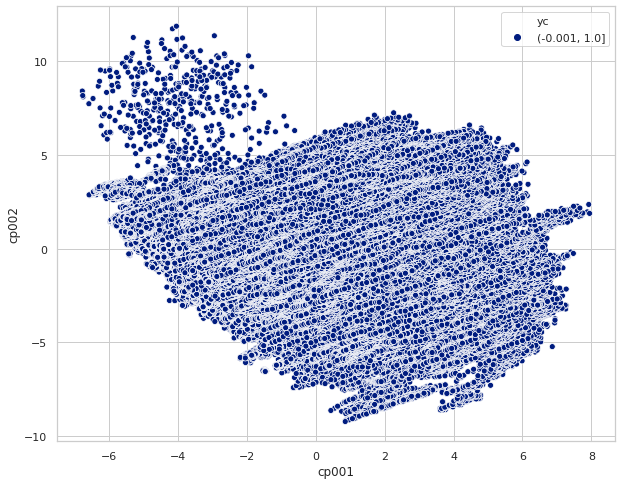

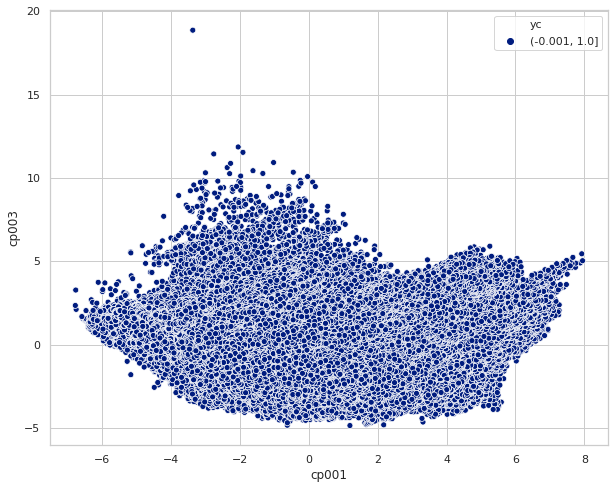

0.1900316643437221

0.19001599723567086

0.019130868295457792

In [24]:
Regresionlineal_PCA(Pichilemu,Pichilemu.drop(columns=['momento']),delta=40)

Dados los resultados gráficos de análisis de componentes, no se aprecian patrones al comparar los componentes.

Realizada la inspección de los diagramas de dispersión, se procede a realizar transformación de la data.

In [25]:
Pichilemu2=Transformar(Pichilemu,10)

Dado que el algoritmo forward arrojó los mejores resultados, se ejecuta nuevamente algoritmo forward con matriz transformada.

formula : ts2 ~ Anno + 1
formula : ts2 ~ qfe1 + 1
formula : ts2 ~ ts + 1
formula : ts2 ~ rr6Horas + 1
formula : ts2 ~ radiacionGlobalInst + 1
formula : ts2 ~ qnh + 1
formula : ts2 ~ p0 + 1
formula : ts2 ~ rrInst + 1
formula : ts2 ~ tMin12Horas + 1
formula : ts2 ~ Hora_Min_t + 1
formula : ts2 ~ dd02Minutos + 1
formula : ts2 ~ rr24Horas + 1
formula : ts2 ~ Hora + 1
formula : ts2 ~ qff + 1
formula : ts2 ~ dd10Minutos + 1
formula : ts2 ~ tMax12Horas + 1
formula : ts2 ~ radiacionGlobalAcumulada24Horas + 1
formula : ts2 ~ td + 1
formula : ts2 ~ ddInst + 1
formula : ts2 ~ ff10Minutos + 1
formula : ts2 ~ Minuto + 1
formula : ts2 ~ Hora_Max_t + 1
formula : ts2 ~ ff02Minutos + 1
formula : ts2 ~ ffInst + 1
formula : ts2 ~ hr + 1
formula : ts2 ~ Mes + 1
formula : ts2 ~ Dia + 1
formula : ts2 ~ td + Anno + 1
formula : ts2 ~ td + qfe1 + 1
formula : ts2 ~ td + ts + 1
formula : ts2 ~ td + rr6Horas + 1
formula : ts2 ~ td + radiacionGlobalInst + 1
formula : ts2 ~ td + qnh + 1
formula : ts2 ~ td + p0 + 1


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
================================================================================
Model:                   Logit                 Pseudo R-squared:      0.815     
Dependent Variable:      ts                    AIC:                   30313.4059
Date:                    2020-07-02 00:59      BIC:                   30623.6971
No. Observations:        723797                Log-Likelihood:        -15130.   
Df Model:                26                    LL-Null:               -81861.   
Df Residuals:            723770                LLR p-value:           0.0000    
Converged:               1.0000                Scale:                 1.0000    
No. Iterations:          13.0000                                                
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
rrInst                           9.0357   1.8812   4.8032 0.0000  5.3487 12.7227
rr6Horas                        -0.1989   0.1030  -1.9302 0.0536 -0.4008  0.0031
rr24Horas                        0.5595   0.0557  10.0448 0.0000  0.4503  0.6686
hr                               0.1151   0.0175   6.5715 0.0000  0.0808  0.1494
p0                               0.0537   0.0605   0.8867 0.3753 -0.0650  0.1723
qfe1                            -0.1695   0.1095  -1.5481 0.1216 -0.3841  0.0451
qff                             -0.0614   0.0104  -5.9225 0.0000 -0.0817 -0.0411
qnh                              0.2804   0.1164   2.4084 0.0160  0.0522  0.5086
radiacionGlobalInst             -0.8413   0.0215 -39.1527 0.0000 -0.8834 -0.7992
radiacionGlobalAcumulada24Horas  0.4899   0.0636   7.6990 0.0000  0.3652  0.6146
ddInst                          -0.0542   0.0236  -2.2975 0.0216 -0.1004 -0.0080
ffInst                          -0.0181   0.0234  -0.7734 0.4393 -0.0639  0.0277
dd02Minutos                     -0.0393   0.0164  -2.3923 0.0167 -0.0715 -0.0071
ff02Minutos                     -0.1323   0.0270  -4.9017 0.0000 -0.1852 -0.0794
dd10Minutos                      0.1005   0.0257   3.9058 0.0001  0.0501  0.1510
ff10Minutos                      0.2528   0.0151  16.7373 0.0000  0.2232  0.2824
ts                              -1.5319   0.0920 -16.6436 0.0000 -1.7122 -1.3515
td                              -0.7345   0.0932  -7.8821 0.0000 -0.9171 -0.5518
tMin12Horas                     -0.0890   0.0132  -6.7573 0.0000 -0.1149 -0.0632
tMax12Horas                     -0.0900   0.0160  -5.6259 0.0000 -0.1213 -0.0586
Anno                             0.0320   0.0053   6.0231 0.0000  0.0216  0.0424
Mes                             -0.0080   0.0145  -0.5556 0.5785 -0.0364  0.0203
Dia                              0.0044   0.0019   2.3722 0.0177  0.0008  0.0081
Hora                            -0.0006   0.0049  -0.1330 0.8942 -0.0102  0.0089
Minuto                           0.0004   0.0009   0.4653 0.6417 -0.0013  0.0021
Hora_Min_t                      -0.0360   0.0048  -7.5053 0.0000 -0.0454 -0.0266
Hora_Max_t                       0.0235   0.0056   4.1673 0.0000  0.0124  0.0345
================================================================================

"""

{'gini': 0.9745936466385986, 'entropy': 0.9755446521254166}
Confusion Matrix :
        0     1
0  300926  1591
1    1679  6002
Accuracy Score : 0.9894583459596774
Report : 
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    302517
         1.0       0.79      0.78      0.79      7681

    accuracy                           0.99    310198
   macro avg       0.89      0.89      0.89    310198
weighted avg       0.99      0.99      0.99    310198

ROC_AUC_score:
0.9961878768352753


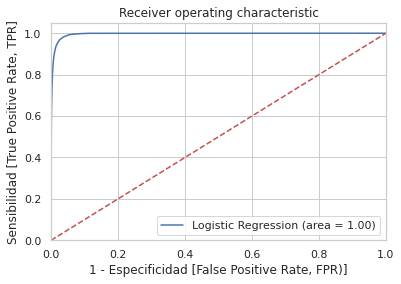

In [26]:
Forward(Pichilemu,Pichilemu2.drop(columns=['momento']))

Al ejecutar forward sobre data transformada, se aprecia una leve reducción del porcentaje de accurady (98,95%) pero una mejora en la matriz de confusión en lo que respecta a falsos negativos.

Se procede a realizar forward con data Escalar

In [27]:
Pichilemu3=escalar(Pichilemu2)

formula : ts2 ~ Anno + 1
formula : ts2 ~ qfe1 + 1
formula : ts2 ~ ts + 1
formula : ts2 ~ rr6Horas + 1
formula : ts2 ~ radiacionGlobalInst + 1
formula : ts2 ~ qnh + 1
formula : ts2 ~ p0 + 1
formula : ts2 ~ rrInst + 1
formula : ts2 ~ tMin12Horas + 1
formula : ts2 ~ Hora_Min_t + 1
formula : ts2 ~ dd02Minutos + 1
formula : ts2 ~ rr24Horas + 1
formula : ts2 ~ Hora + 1
formula : ts2 ~ qff + 1
formula : ts2 ~ dd10Minutos + 1
formula : ts2 ~ tMax12Horas + 1
formula : ts2 ~ radiacionGlobalAcumulada24Horas + 1
formula : ts2 ~ td + 1
formula : ts2 ~ ddInst + 1
formula : ts2 ~ ff10Minutos + 1
formula : ts2 ~ Minuto + 1
formula : ts2 ~ Hora_Max_t + 1
formula : ts2 ~ ff02Minutos + 1
formula : ts2 ~ ffInst + 1
formula : ts2 ~ hr + 1
formula : ts2 ~ Mes + 1
formula : ts2 ~ Dia + 1
formula : ts2 ~ td + Anno + 1
formula : ts2 ~ td + qfe1 + 1
formula : ts2 ~ td + ts + 1
formula : ts2 ~ td + rr6Horas + 1
formula : ts2 ~ td + radiacionGlobalInst + 1
formula : ts2 ~ td + qnh + 1
formula : ts2 ~ td + p0 + 1


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
================================================================================
Model:                    Logit                Pseudo R-squared:     -2.744     
Dependent Variable:       ts                   AIC:                  613042.7068
Date:                     2020-07-02 01:09     BIC:                  613352.9980
No. Observations:         723797               Log-Likelihood:       -3.0649e+05
Df Model:                 26                   LL-Null:              -81861.    
Df Residuals:             723770               LLR p-value:          1.0000     
Converged:                1.0000               Scale:                1.0000     
No. Iterations:           8.0000                                                
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
rrInst                          -0.0029   0.0030  -0.9439 0.3452 -0.0088  0.0031
rr6Horas                        -0.0231   0.0039  -5.9817 0.0000 -0.0307 -0.0155
rr24Horas                        0.2837   0.0041  68.9767 0.0000  0.2756  0.2917
hr                              -0.6654   0.0343 -19.3860 0.0000 -0.7327 -0.5981
p0                               0.2091   0.0395   5.2973 0.0000  0.1317  0.2865
qfe1                            -0.4488   0.0718  -6.2514 0.0000 -0.5896 -0.3081
qff                              0.4828   0.0114  42.4841 0.0000  0.4605  0.5051
qnh                             -0.0935   0.0753  -1.2406 0.2148 -0.2411  0.0542
radiacionGlobalInst              0.1124   0.0058  19.3152 0.0000  0.1010  0.1238
radiacionGlobalAcumulada24Horas  0.2310   0.0048  48.4745 0.0000  0.2216  0.2403
ddInst                           0.0833   0.0044  19.0687 0.0000  0.0747  0.0918
ffInst                          -0.0030   0.0107  -0.2763 0.7823 -0.0240  0.0181
dd02Minutos                     -0.0490   0.0045 -10.8845 0.0000 -0.0579 -0.0402
ff02Minutos                      0.0085   0.0137   0.6189 0.5360 -0.0183  0.0353
dd10Minutos                     -0.0353   0.0039  -8.9940 0.0000 -0.0430 -0.0276
ff10Minutos                      0.1643   0.0098  16.8530 0.0000  0.1452  0.1835
ts                              -1.4843   0.0482 -30.7812 0.0000 -1.5788 -1.3898
td                               0.7542   0.0494  15.2816 0.0000  0.6575  0.8510
tMin12Horas                     -0.4413   0.0073 -60.2028 0.0000 -0.4556 -0.4269
tMax12Horas                      0.0453   0.0083   5.4309 0.0000  0.0290  0.0617
Anno                             2.4114   0.0068 356.0965 0.0000  2.3981  2.4247
Mes                              1.8300   0.0061 302.2067 0.0000  1.8181  1.8419
Dia                              0.0441   0.0031  14.0623 0.0000  0.0380  0.0503
Hora                             0.0349   0.0055   6.2951 0.0000  0.0240  0.0457
Minuto                           0.0007   0.0031   0.2178 0.8276 -0.0055  0.0068
Hora_Min_t                      -0.2019   0.0036 -55.5110 0.0000 -0.2090 -0.1948
Hora_Max_t                       0.3049   0.0066  46.4781 0.0000  0.2920  0.3178
================================================================================

"""

{'gini': 0.974287390634369, 'entropy': 0.9772919232232317}
Confusion Matrix :
        0       1
0  192679  109838
1     661    7020
Accuracy Score : 0.6437791346172445
Report : 
              precision    recall  f1-score   support

         0.0       1.00      0.64      0.78    302517
         1.0       0.06      0.91      0.11      7681

    accuracy                           0.64    310198
   macro avg       0.53      0.78      0.44    310198
weighted avg       0.97      0.64      0.76    310198

ROC_AUC_score:
0.7028528139270029


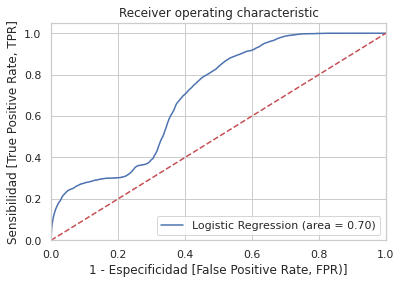

In [28]:
Forward(Pichilemu,Pichilemu3)

Al ejecutar Forward con data Escalada, se aprecia una baja notable en el accuracy del algoritmo (64,38%), y una alza en los falsos positivos en su matriz de confusión.
Por otra parte, su curva ROC muestra una sensibilidad que se incrementa muy lentamente en relación a 1 - Especificidad comparado con las curvas revisadas anteriormente en los casos de estudio.

# V. Conclusiones

Una vez concluido este análisis, podemos emitir las siguientes conclusiones:

* Para poder desarrollar un análisis concreto en relación a las variables de la Base de Datos, se realizó actividad para desglosar las variables temporales como años, meses, días, horas y minutos, también se calculó Hora_Min_t y Hora_Max_t.
* Se implementaron funciones para poder facilitar la ejecución de nuestro trabajo y así presentar un código limpio y escalable.
* Dadas las características de la base de datos utilizada, se implementó código para conciliar en un solo dataframe el conjunto de los datos climáticos a analizar.
* Se visualizan correlaciones y variables en el tiempo, no se presentaron datos NaN durante el análisis inicial y se analizó matriz de correlaciones vs variables a predecir (ts).
* Se grafican densidades de variables de la base de datos
    * Al revisar las densidades, definimos aplicar las siguientes transformaciones a los siguientes datos:
        * Transformación logarítmica: radiacionGlobalInst, radiacionGlobalAcumulada24Horas, rr24Horas, rr6Horas, rrInst, ddInst, dd02Minutos, dd10Minutos
        * Transformación categóricas (bins = 10): p0, qfe1, 
* Se obtiene la ganancia (IG) y valor (IV) de la información de las variables de la base de datos, se usó un sample de 20 mil registros, un delta (tiempo de desfase) de 40 minutos entre la lectura de los datos y su respuesta, y un límite de 7 grados como temperatura baja:
    * Dados los resultados de las funciones, las variables Anno, Mes, rrInst, Hora, Dia, Hora_Max_t, Hora_Min_t, Minuto, tMax12Horas y tMin12Horas, presentan bajo IG e IV, por lo que se puede presumir que nos buenos predictores para establecer la temperatura. 
* El Árbol de Decisión arroja un Accuracy del 98,92%, BackWard_Logit un  98,98% y el Forward un 98,99%
* En cuanto a matriz de confusión, tanto Backward como Forward presentan mejora accuracy, por lo que privilegia aquel que presenta mejor reducción de falsos negativos, es decir, modelo Forward.
* Se analizan los gráficos de componentes y no se aprecian patrones al compararlos.
* Dado que el algoritmo forward arrojó los mejores resultados, se ejecuta nuevamente algoritmo forward con matriz transformada.
* Al ejecutar Forward con data transformada, se aprecia una leve reducción del porcentaje de accurady (98,95%) pero una mejora en la matriz de confusión en lo que respecta a falsos negativos.
* Al ejecutar Forward con data Escalada, se aprecia una baja notable en el accuracy del algoritmo (64,38%), Por lo que se descarta como un algoritmo apropiado para predecir.


* Por lo tanto, dado el análisis realizado con los modelos desarrollados, se concluye que la mejor alternativa de predicción de una temperatura bajo el límite estudiado es aplicando algoritmo Forward con data transformada ya que presenta un accuracy mayor a 95% y un error tipo 2 menor.

## Resumen Comparativo Modelos

<img src="ResumenMatricesConfusion.png">